In [1]:
import os
import glob

import tables as tb
import numpy  as np
import pandas as pd

from collections import defaultdict
from scipy import interpolate

from invisible_cities.core import core_functions as coref

import invisible_cities.io.pmaps_io as pmapio
import invisible_cities.io.dst_io  as dstio
import invisible_cities.io.mcinfo_io as mcio
import gres.database.load_db as db
import invisible_cities.io.run_and_event_io as rio

from lmfit.models import GaussianModel, LinearModel, ExponentialModel, SkewedGaussianModel, ConstantModel, RectangleModel


In [2]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib notebook
%matplotlib inline
### Useful parameters for plots
mpl.rcParams["figure.figsize"]          = 12,10
mpl.rcParams["font.size"]               = 20
mpl.rcParams["figure.max_open_warning"] = 100
mpl.rcParams["font.size"]               = 20
mpl.rcParams["font.weight"]             ='normal'
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['figure.facecolor'] = 'w';

In [3]:
def sel_trange_s2(dataset, s2_tbins, fDraw=False, ax=None):
    y, x, *_ = np.histogram(dataset.s2_t, s2_tbins);
    
    x  = coref.shift_to_bin_centers(x)
    xd = x.copy()
    yd = y.copy()
    #sel_f = coref.in_range(xd, *efit)
    
    mod   = GaussianModel(prefix='g1_')
    mod   = SkewedGaussianModel(prefix='g1_')
    mod1  = ConstantModel(prefix='c1_')
    mod2  = SkewedGaussianModel(prefix='g1_')
    mod   = mod1 + mod2
    pars1 = mod1.guess(yd, x=xd)
    pars2 = mod2.guess(yd, x=xd)
    pars  = pars1+pars2
    
    out = mod.fit(yd, pars, x=xd)
    result =  out.result.params

    if fDraw:
        if not ax:
            plt.figure()
            ax = plt.gca()
        ax.hist(dataset.s2_t, s2_tbins);

    mode   = xd[out.best_fit.argmax()]
    mode_e = np.sqrt(np.sum([(r.stderr/r.value)**2 for r in result.values()])) * mode
    mu     = np.array([result['g1_center'].value, result['g1_center'].stderr])
    sigma  = np.array([result['g1_sigma' ].value, result['g1_sigma' ].stderr])
    trange_s2 = [mode - 3*sigma[0], mode+3*sigma[0]]

    if fDraw:
        ax.plot(xd, out.best_fit, '-', c='r')
        ax.axvline(mode, c='k')
    
    return np.array([mode, mode_e]), trange_s2

In [4]:
def sel_erange_s2(dataset, s2_ebins, fDraw=False, ax=None):
    y, x, *_ = np.histogram(dataset.s2_energy, s2_ebins);
    
    x  = coref.shift_to_bin_centers(x)
    xd = x.copy()
    yd = y.copy()
    #sel_f = coref.in_range(xd, *efit)
    
    mod   = GaussianModel(prefix='g1_')
    mod   = SkewedGaussianModel(prefix='g1_')
    #mod1  = ConstantModel(prefix='c1_')
    #mod2  = SkewedGaussianModel(prefix='g1_')
    #mod   = mod1 + mod2
    #pars1 = mod1.guess(yd, x=xd)
    #pars2 = mod2.guess(yd, x=xd)
    pars  = mod.guess(yd, x=xd)#pars1+pars2
    
    
    out = mod.fit(yd, pars, x=xd)
    result =  out.result.params
    #print(result)
    if fDraw:
        if not ax:
            plt.figure()
            ax = plt.gca()
        ax.hist(dataset.s2_energy, s2_ebins);

    mode   = xd[out.best_fit.argmax()]
    mode_e = np.sqrt(np.sum([(r.stderr/r.value)**2 for r in result.values()])) * mode
    mode_e = np.sqrt(np.sum([(r.stderr/r.value)**2 for r in result.values() if r.name != 'g1_gamma'])) * mode
    mu     = np.array([result['g1_center'].value, result['g1_center'].stderr])
    sigma  = np.array([result['g1_sigma' ].value, result['g1_sigma' ].stderr])

    nsigma = 3
    trange_s2 = [mode - 3*sigma[0], mode+3*sigma[0]]

    if fDraw:
        ax.plot(xd, out.best_fit, '-', c='r')
        ax.axvline(mode, c='k')
    
    return np.array([mode, mode_e]), trange_s2

In [5]:
energies  = np.array([5442.80, 5485.56])
ratio     = np.array([13, 84.5])

alpha_ene = coref.weighted_mean_and_std(energies, ratio)

In [6]:
nfiles = 100000
datatypes = ['22Na', '83mKr', '133Ba', 'NoSource', '57Co', '241Am', '55Fe']#[2]
ws        = np.array([  50.6,   46.3,   36.0,   32.1,  28.9,   25.3])
ws_e      = np.array([   2.6,    2.4,    1.9,    1.6,   1.3,    1.1])
p_ws      = np.array([2.03e5, 4.05e5, 6.08e5, 7.09e5, 8.1e5, 1.01e6]) * 1e-5 #Pa to bar

ws_int    = interpolate.interp1d(p_ws, ws, fill_value='extrapolate')

### Load data

In [7]:
pressure   = 8.44
delta_volt = 5
source     = datatypes[5]
gas        = 'Ar'
drift_dist = 8.7

#sel_run    = 
el_volt    = 5
cath_volts = np.concatenate(([0], np.arange(11.5  ,  el_volt-0.01, -0.5)))
all_runs   = [[1112]] + [[rn] for rn in np.arange(1113, 1126+1, 1)]
max_dv     = 1.5
labels     = [f'{cath_volt:.1f} kV' for cath_volt in cath_volts] 

datasets_s1 = []
datasets_s2 = []

dst_path = '/home/ander/Work/GaP/real_data/241Am/LCE_Study/LCE_and_drift.h5'

for run_numbers in all_runs:    
    data_1_s1 = []
    data_1_s2 = [] 
    
    for run_number in run_numbers:
        inpath = f'/home/ander/Work/GaP/real_data/{source}/R{run_number}/octavia/'
        data_1_s1.append(pd.read_hdf(inpath+f'DST_run_{run_number}_pmaps.h5', 'S1'))
        data_1_s2.append(pd.read_hdf(inpath+f'DST_run_{run_number}_pmaps.h5', 'WVF'))
    
    data_1_s1 = pd.concat(data_1_s1).reset_index(drop=True)    
    data_1_s2 = pd.concat(data_1_s2).reset_index(drop=True)    
    
    data_1_s1['r'] = np.sqrt(data_1_s1.x**2 + data_1_s1.y**2)
    data_1_s2['r'] = np.sqrt(data_1_s2.x**2 + data_1_s2.y**2)
    datasets_s1.append(data_1_s1)
    datasets_s2.append(data_1_s2)

#### Check n-th run

In [11]:
idrun = 2

s1_tbins  = np.linspace(9500, 10500, 101)
trange_s1 = [9900, 10100]

s2_tbins  = np.linspace(40000, 90000, 201)

s1_ebins  = np.linspace(150  , 1200 , 301)
s2_ebins  = np.linspace(20000, 40000, 101)
s2_emax   = s2_ebins.max()/2
sm_bins = np.linspace(200, s1_ebins.max(), 301)
#sm_bins = np.linspace(-150, 200, 301)


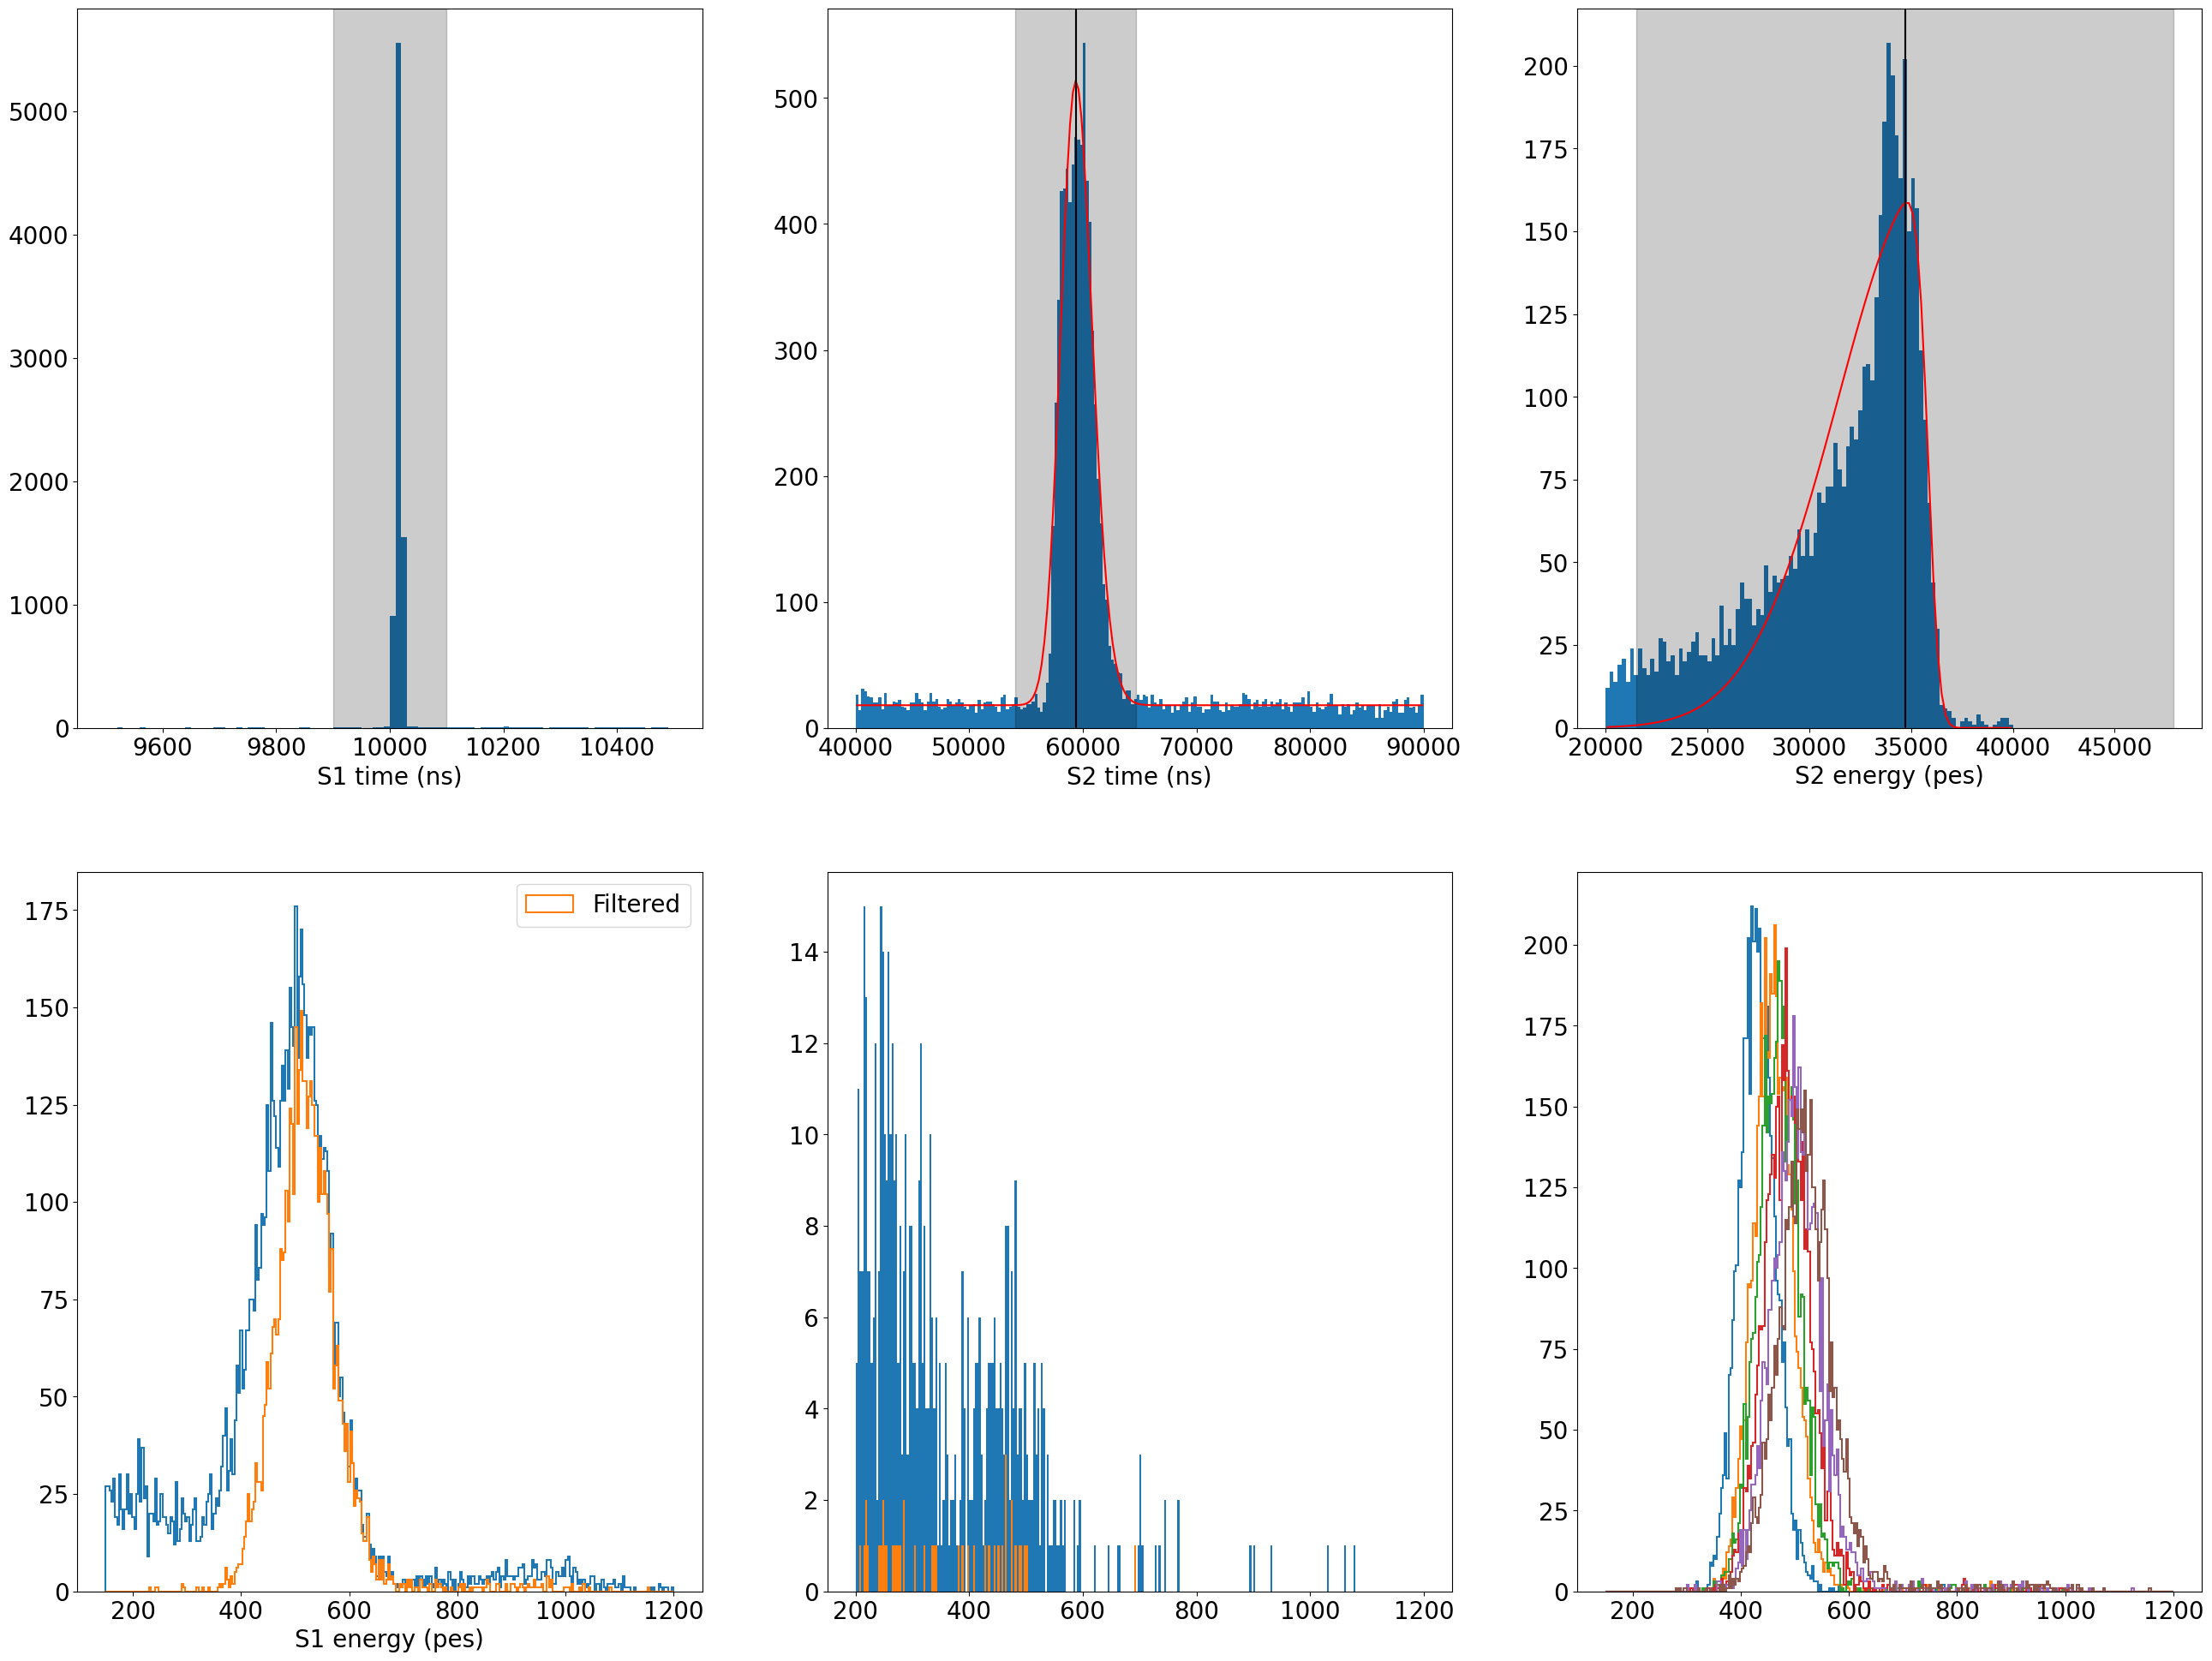

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(32, 24))
axes      = axes.flatten()

data = datasets_s2[idrun]
sel_t_s1  = coref.in_range(data.s1_t, *trange_s1)

axes[0].hist   (data.s1_t, s1_tbins);
axes[0].axvspan(*trange_s1, alpha=0.2, color='k')
axes[0].set_xlabel('S1 time (ns)')

mode, trange_s2  = sel_trange_s2(data, s2_tbins, True, axes[1])
sel_t_s2 = coref.in_range(data.s2_t, *trange_s2)
axes[1].axvspan(*trange_s2, alpha=0.2, color='k')
axes[1].set_xlabel('S2 time (ns)')

#axes[2].hist2d(data.s1_energy, data.s2_energy, [s1_ebins, s2_ebins]);
#axes[2].axhline(s2_emax, c='r', lw=2)
#axes[2].set_xlabel('S1 energy (pes)')
#axes[2].set_ylabel('S2 energy (pes)')


#axes[2].hist(data     .s2_energy, s2_ebins, histtype='step', lw=1.5);
#sel_e_s2  = data.s2_energy > s2_emax
#axes[2].axvline(s2_emax, c='r', lw=2)
s2_e, erange_s2  = sel_erange_s2(data, s2_ebins, True, axes[2])
sel_e_s2 = coref.in_range(data.s2_energy, *erange_s2)
axes[2].axvspan(*erange_s2, alpha=0.2, color='k')
axes[2].set_xlabel('S2 time (ns)')

axes[2].set_xlabel('S2 energy (pes)')
sel = sel_t_s1 & sel_t_s2 & sel_e_s2

axes[3].hist(data     .s1_energy, s1_ebins, histtype='step', lw=1.5);
axes[3].hist(data[sel].s1_energy, s1_ebins, histtype='step', lw=1.5, label='Filtered');
#axes[3].hist(data[sel].s1_energy, s1_ebins, histtype='step', lw=1.5);
axes[3].set_xlabel('S1 energy (pes)')
axes[3].legend()

axes[4].hist(data.mid_energy, sm_bins);
axes[4].hist(data[sel].mid_energy, sm_bins);


s1_vals = np.zeros(len(data[sel]))
for ii in range(6):
    s1_vals +=data[sel][f's1_energy_{ii}']
    axes[5].hist(s1_vals, s1_ebins, histtype='step', lw=1.5);

[1.0183648152491738, 1.0951346423624178, 0.9808269633106229, 1.1789178226054131, 1.297492534896194, 1.1585087518355999]


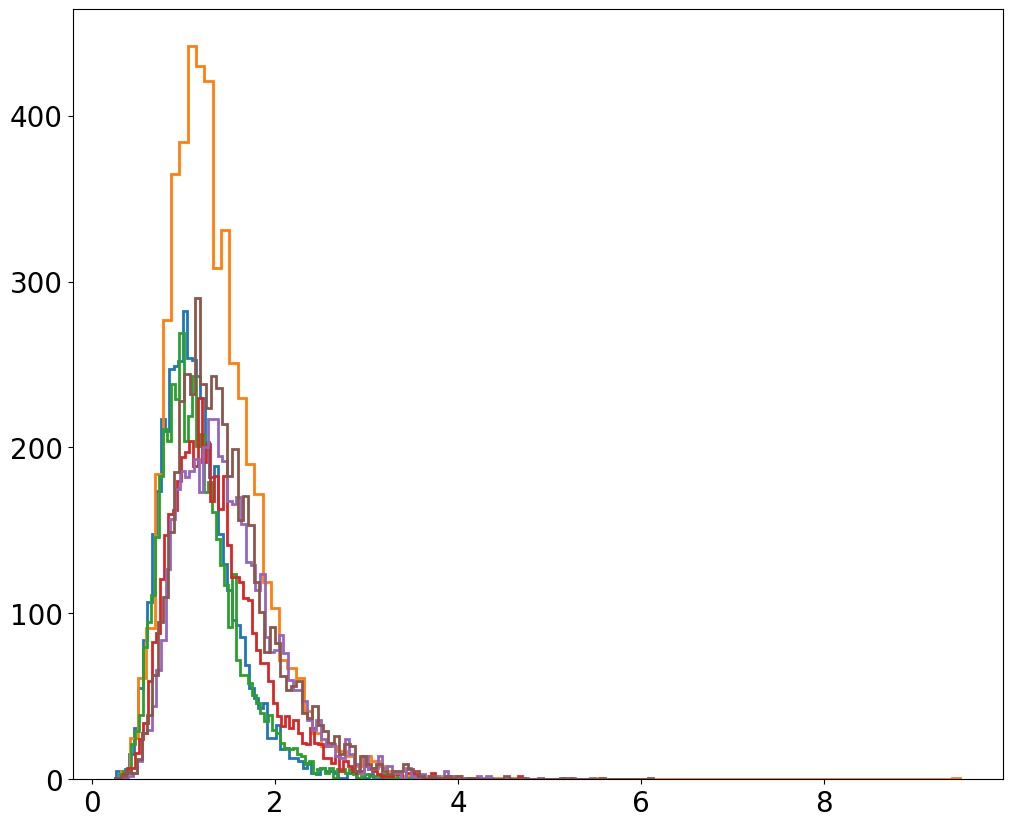

In [13]:
ratio = []

for i in range(1, 7):
    y, x, *_ = plt.hist(data[sel][f'h_pmt0_s1']/data[sel][f'h_pmt{i}_s1'], 101, histtype='step', lw=2);
    x = coref.shift_to_bin_centers(x)
    ratio.append(x[y.argmax()])

print(ratio)

### Loop over data

Run n = 0, (0.0 kV)
Run n = 1, (11.5 kV)
Run n = 2, (11.0 kV)
Run n = 3, (10.5 kV)
Run n = 4, (10.0 kV)
Run n = 5, (9.5 kV)
Run n = 6, (9.0 kV)
Run n = 7, (8.5 kV)
Run n = 8, (8.0 kV)
Run n = 9, (7.5 kV)
Run n = 10, (7.0 kV)
Run n = 11, (6.5 kV)
Run n = 12, (6.0 kV)
Run n = 13, (5.5 kV)
Run n = 14, (5.0 kV)


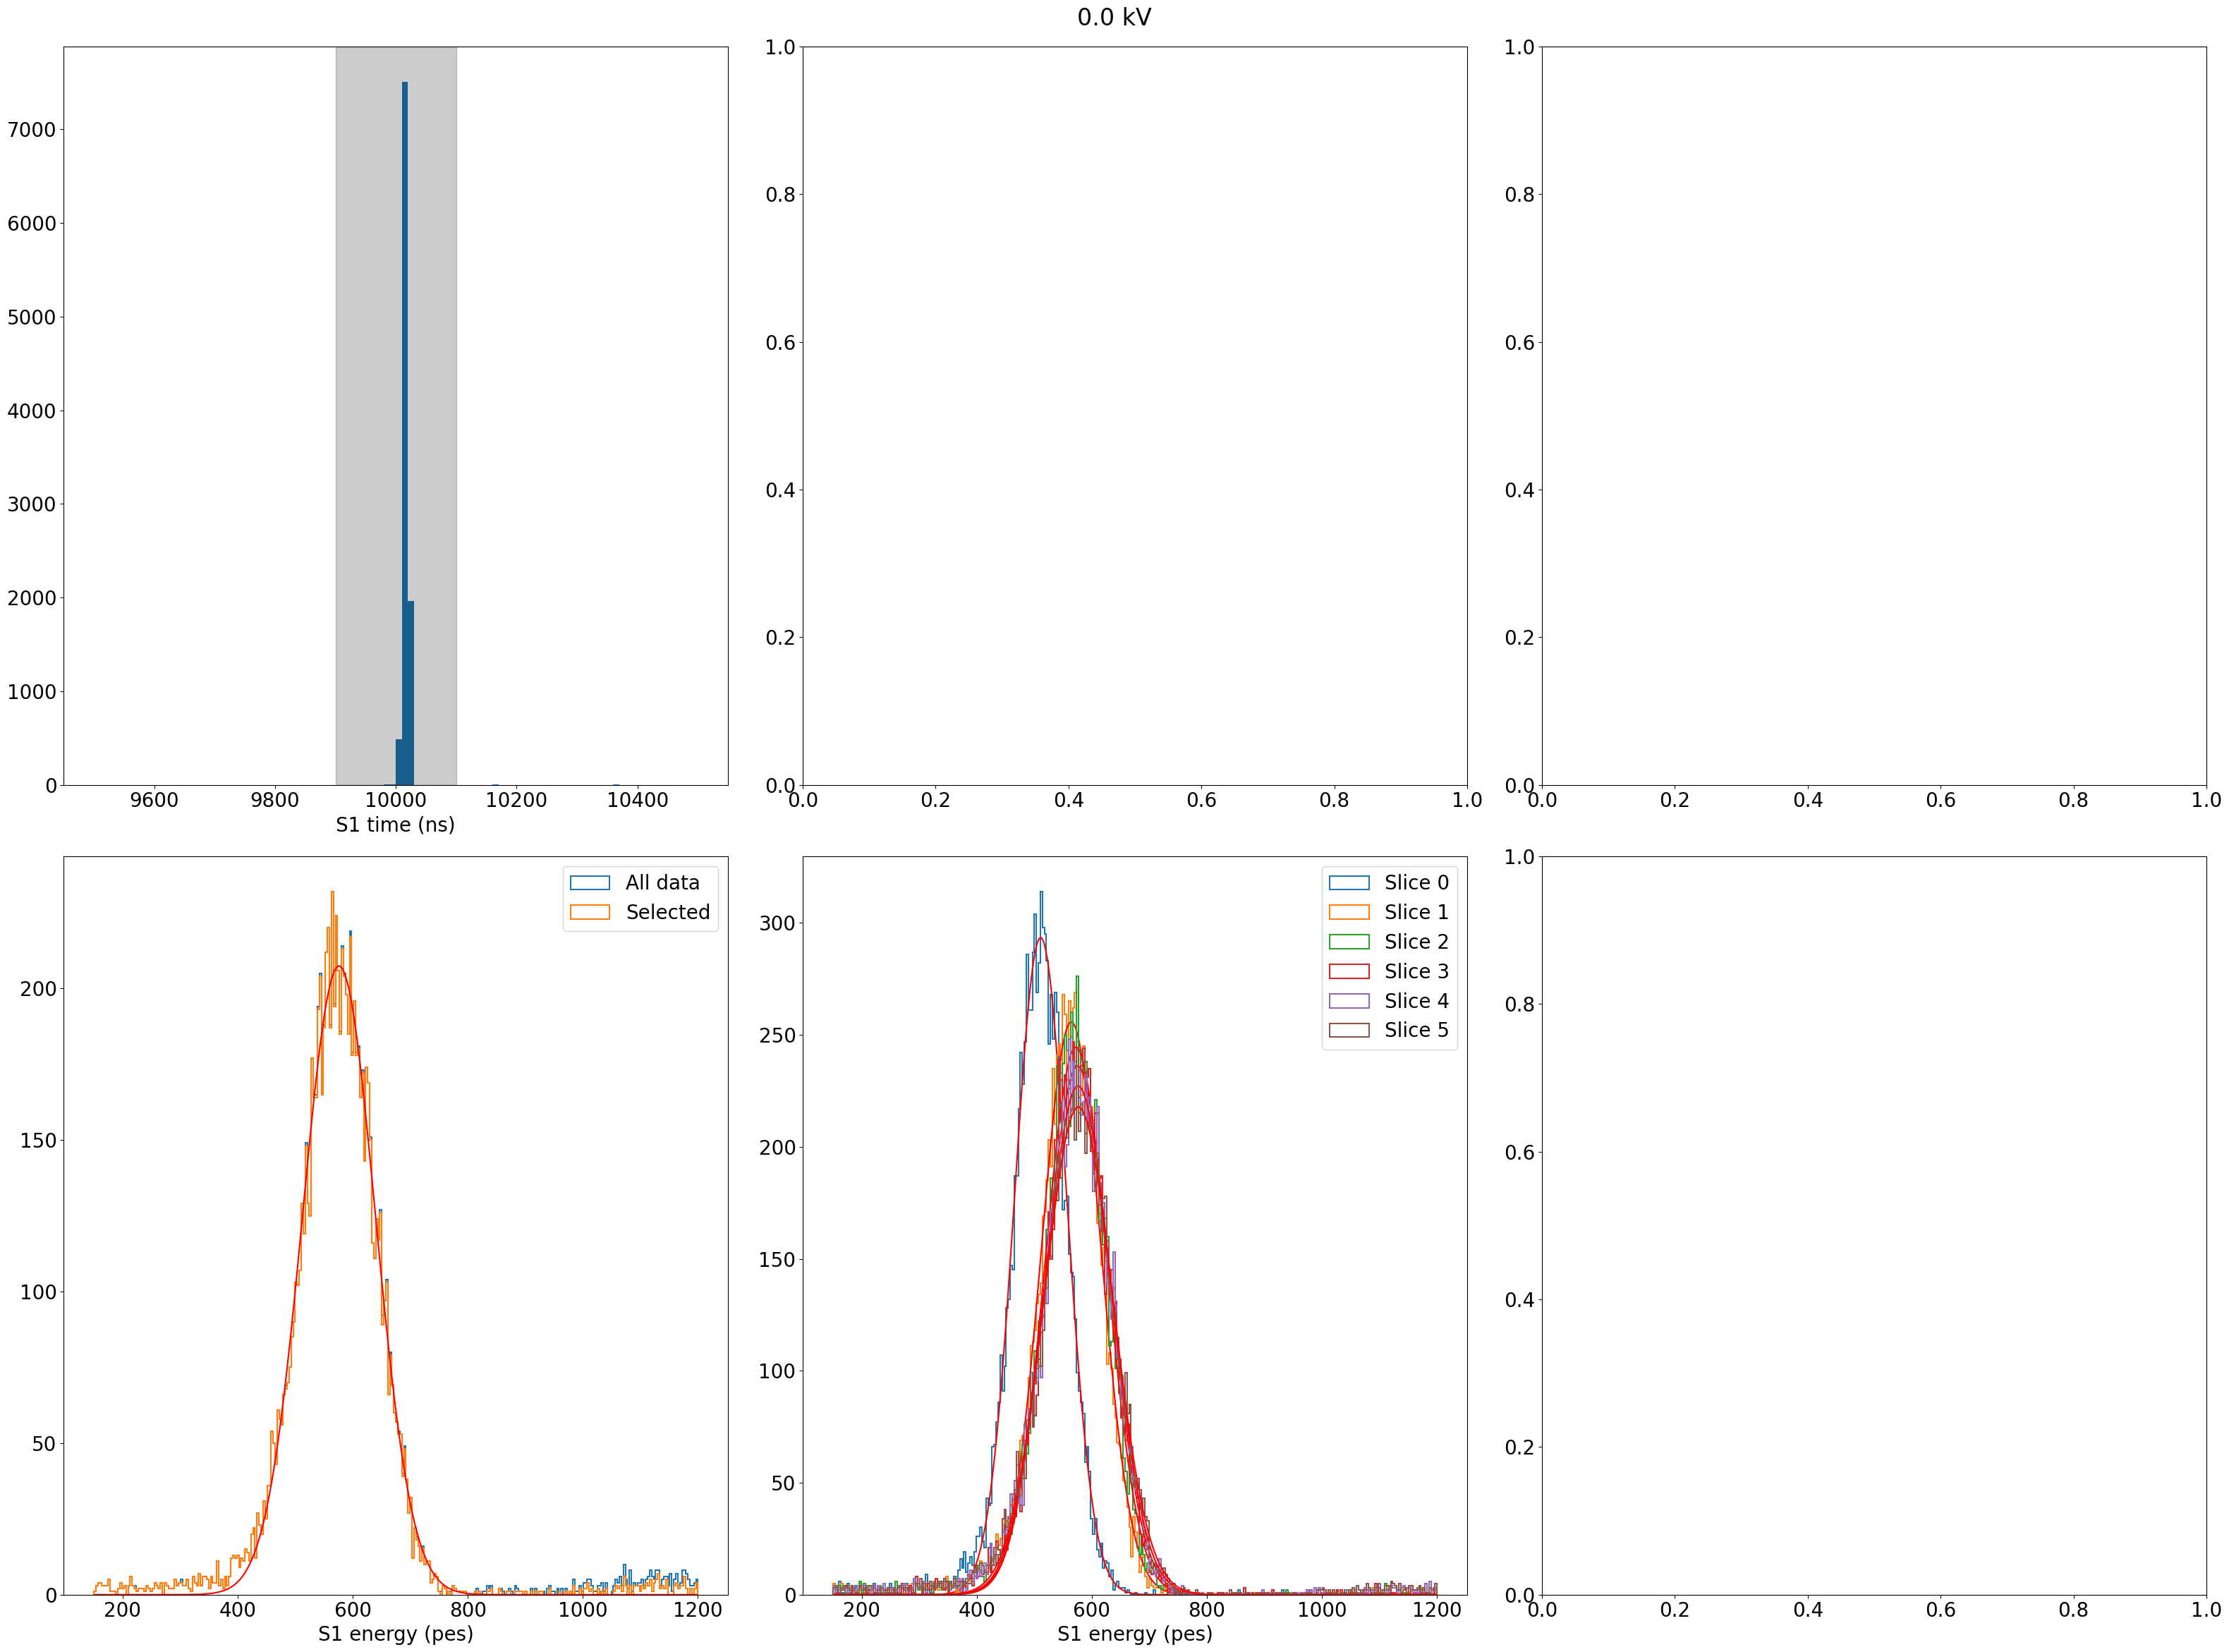

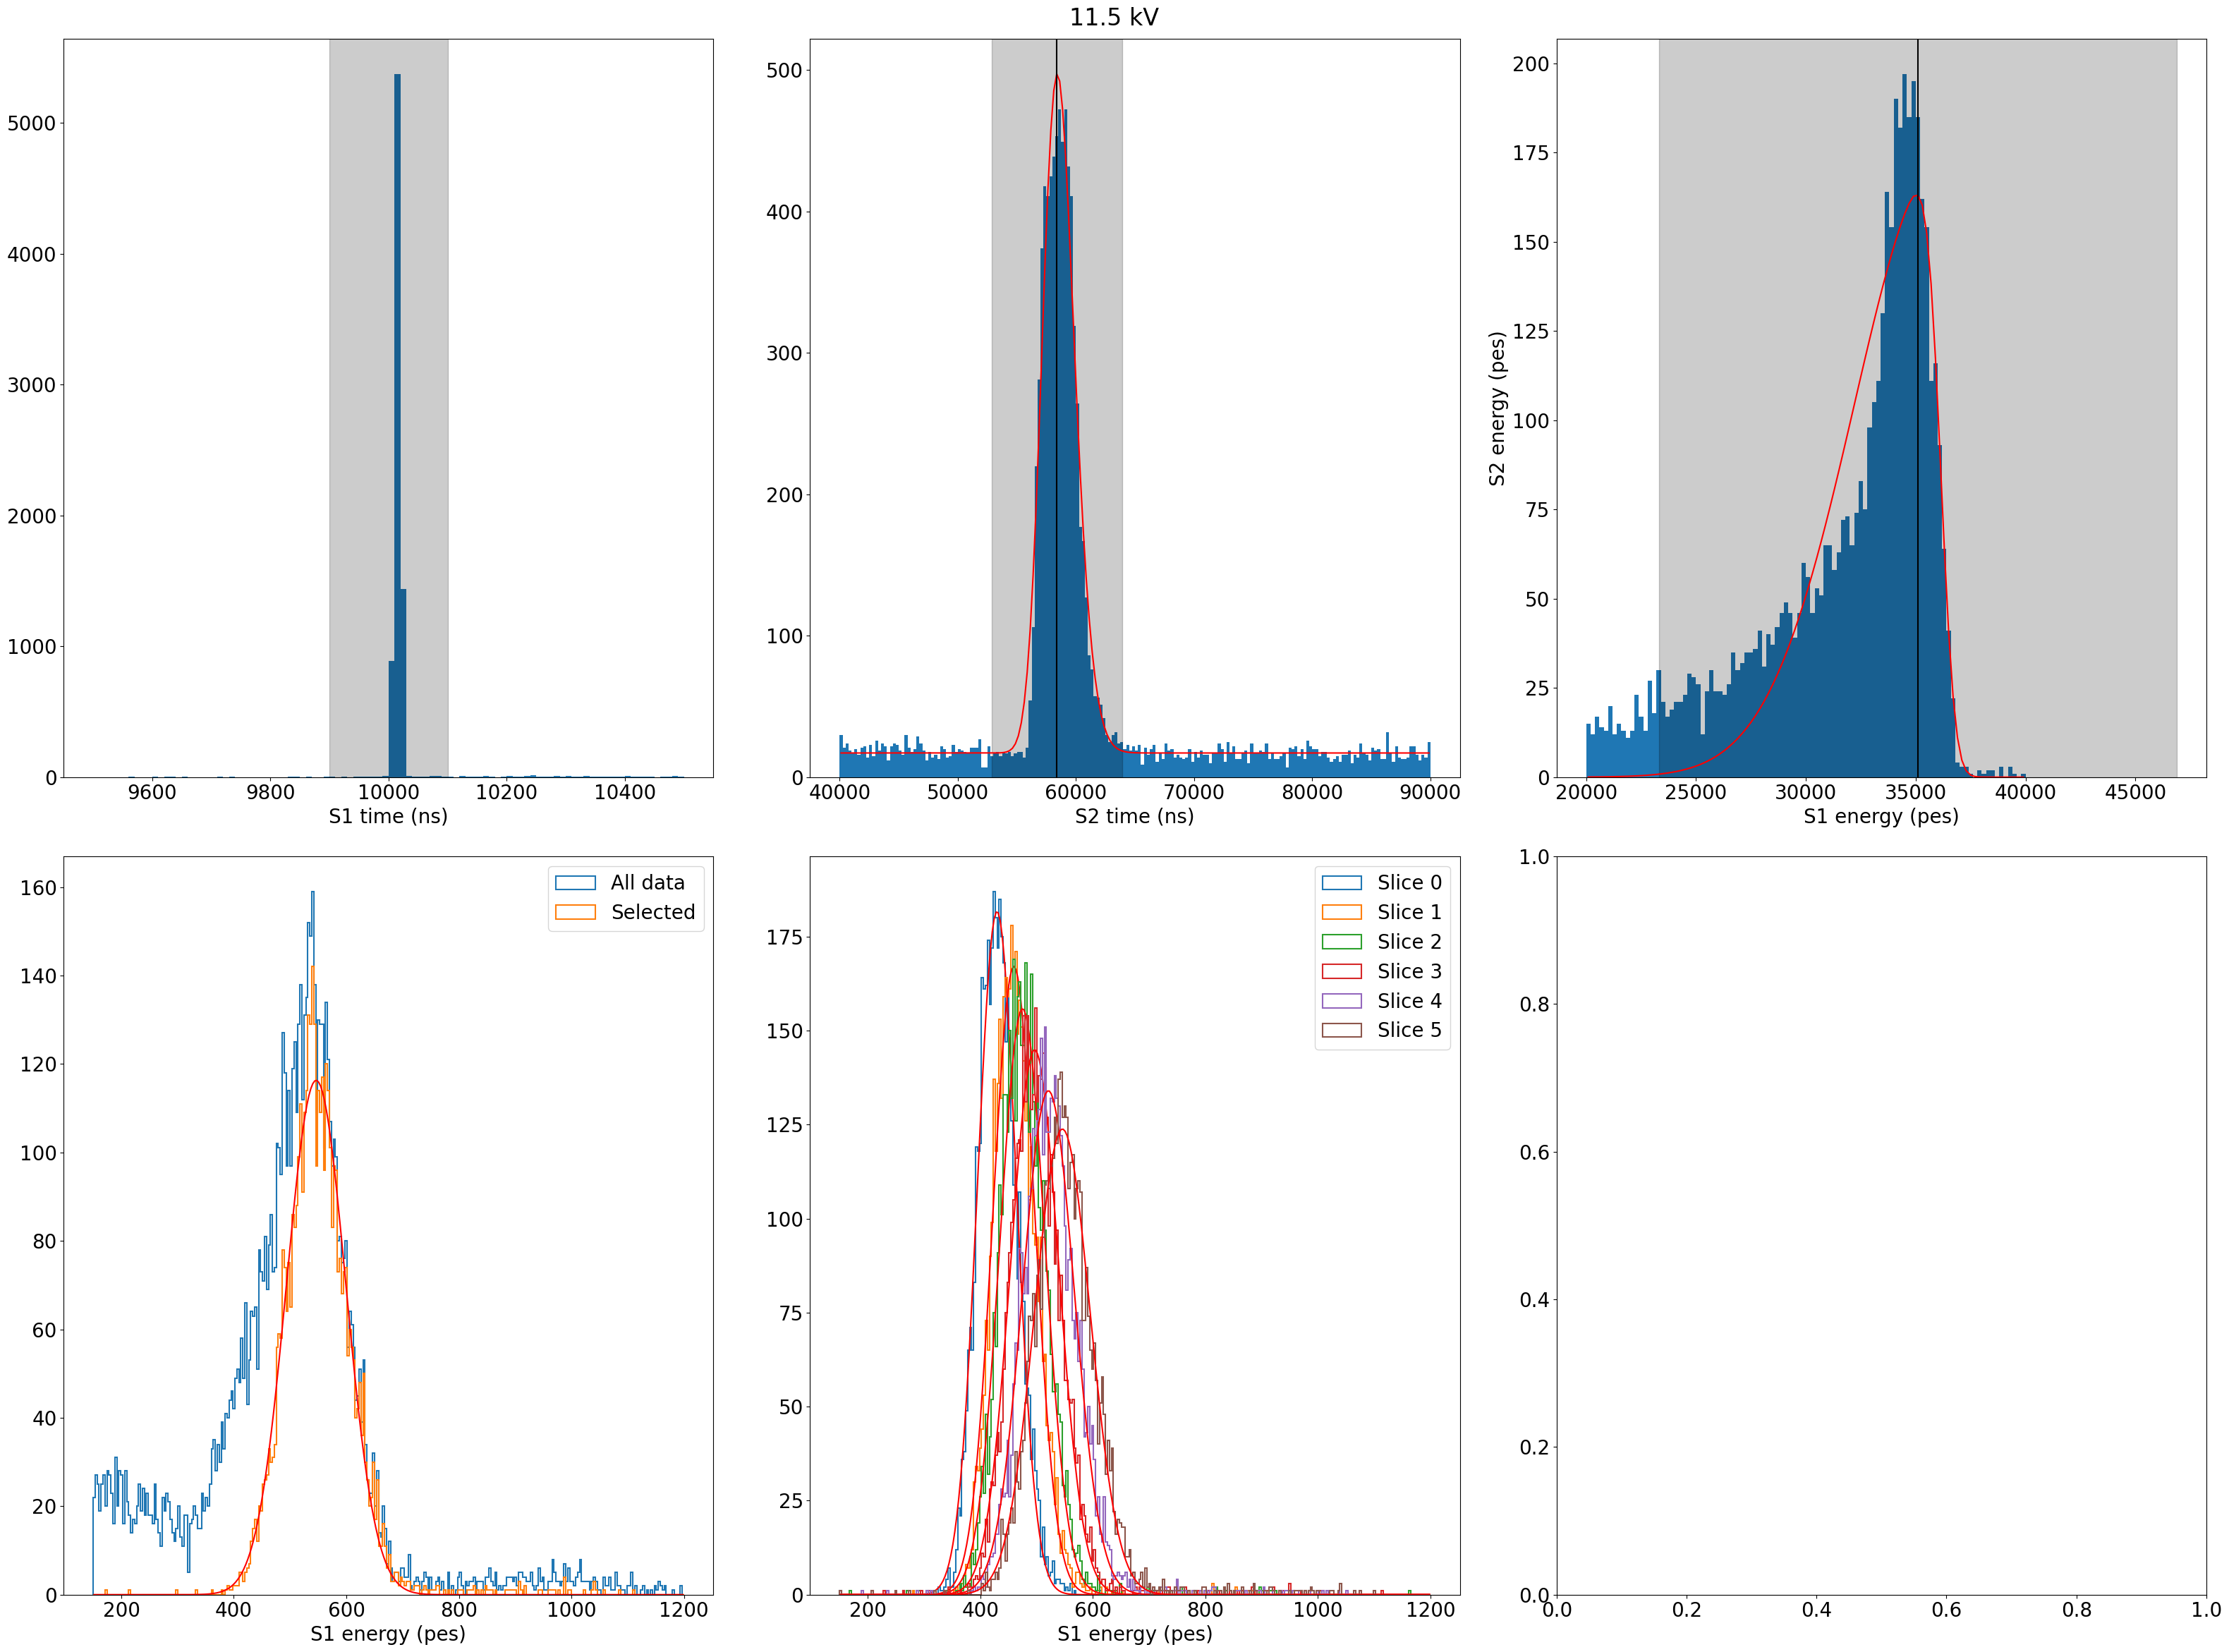

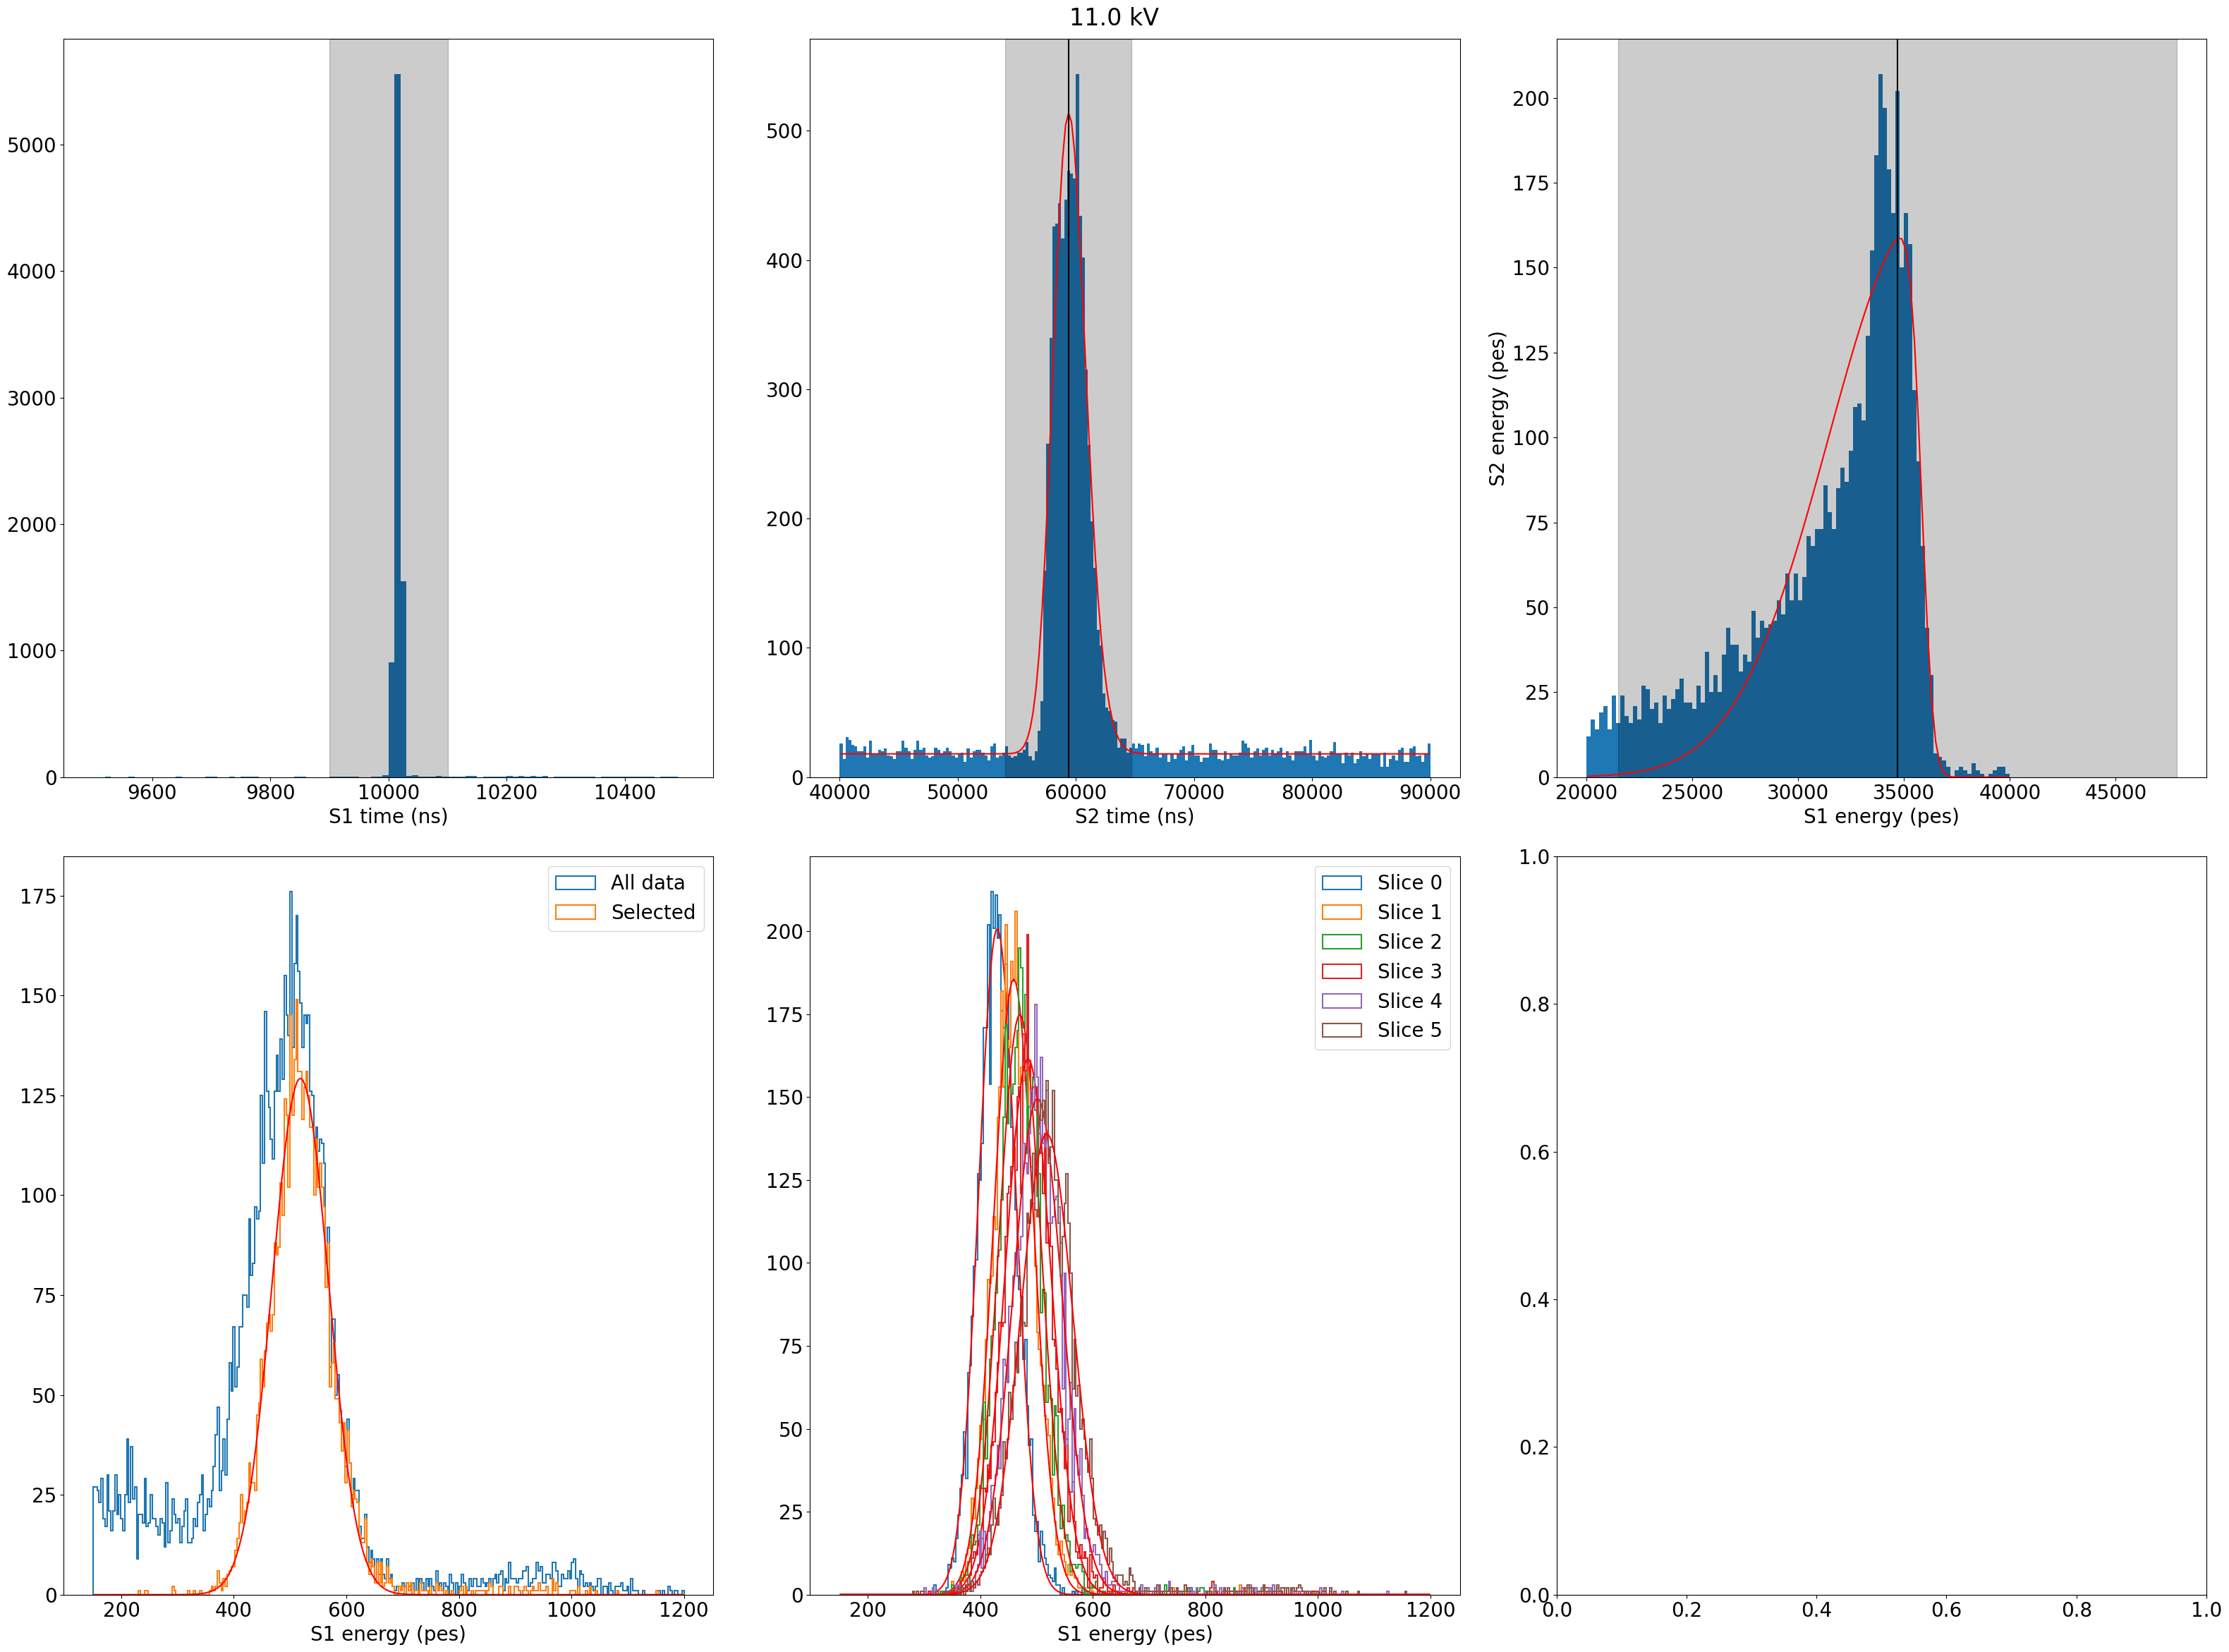

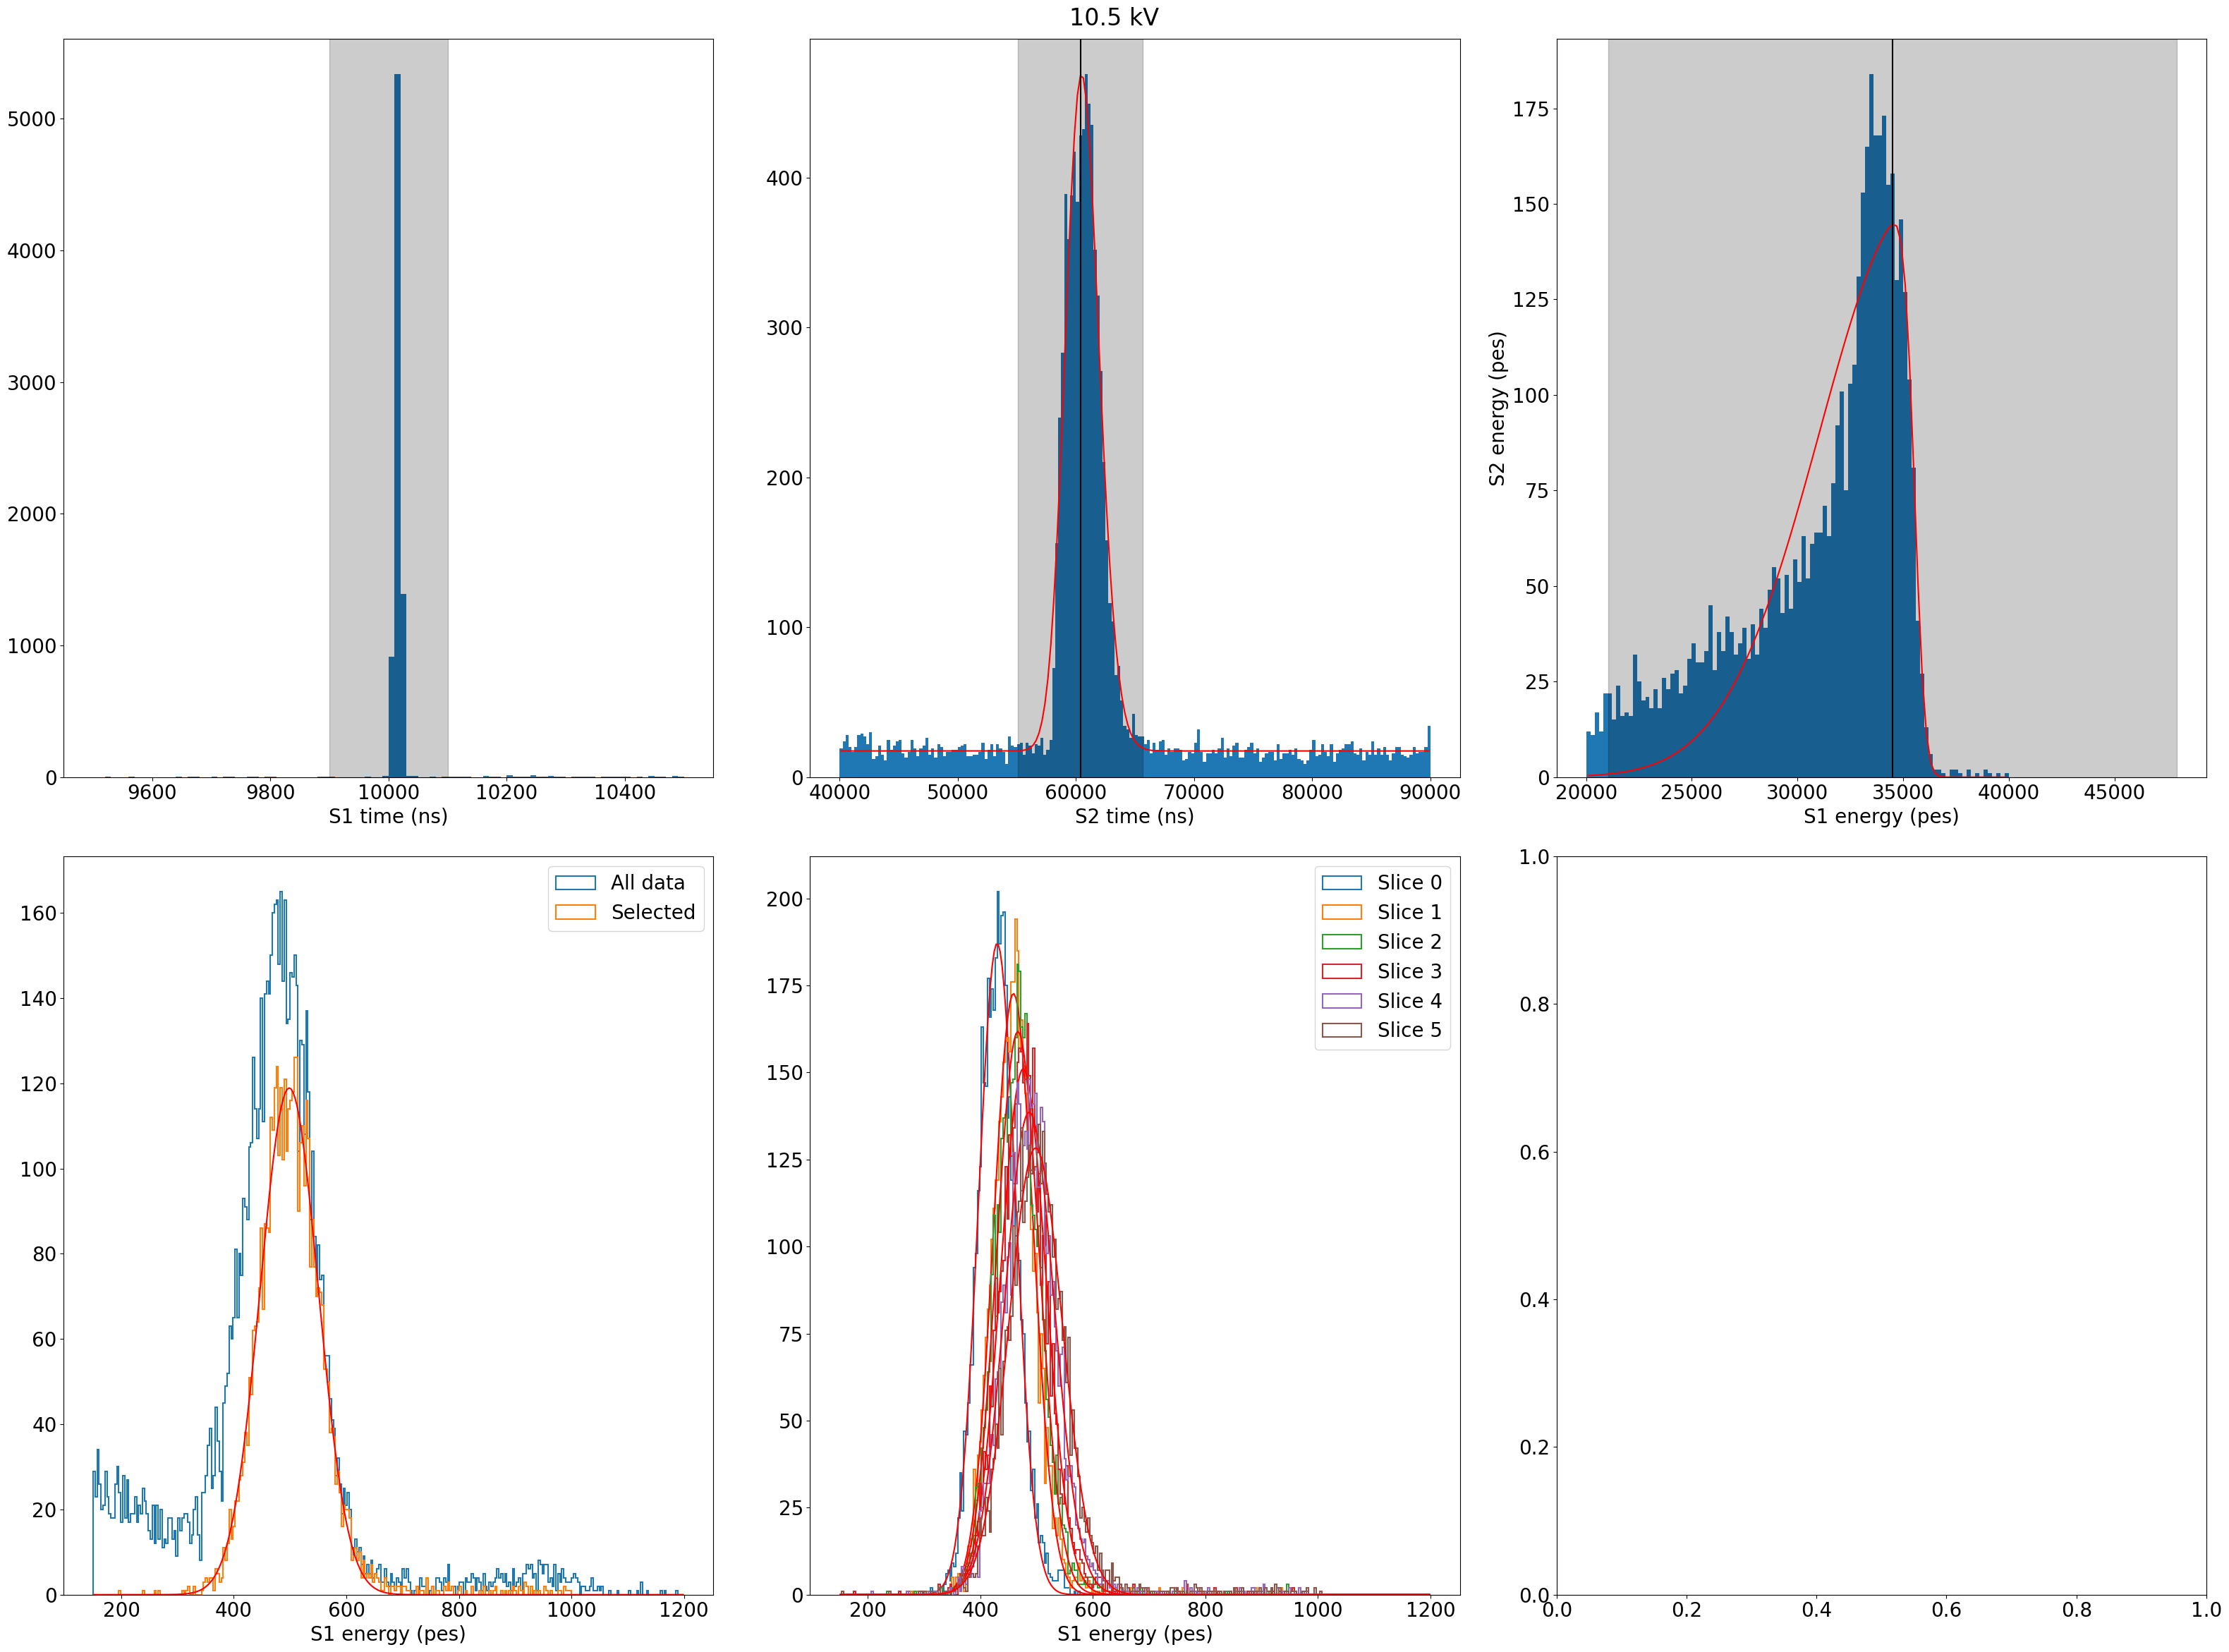

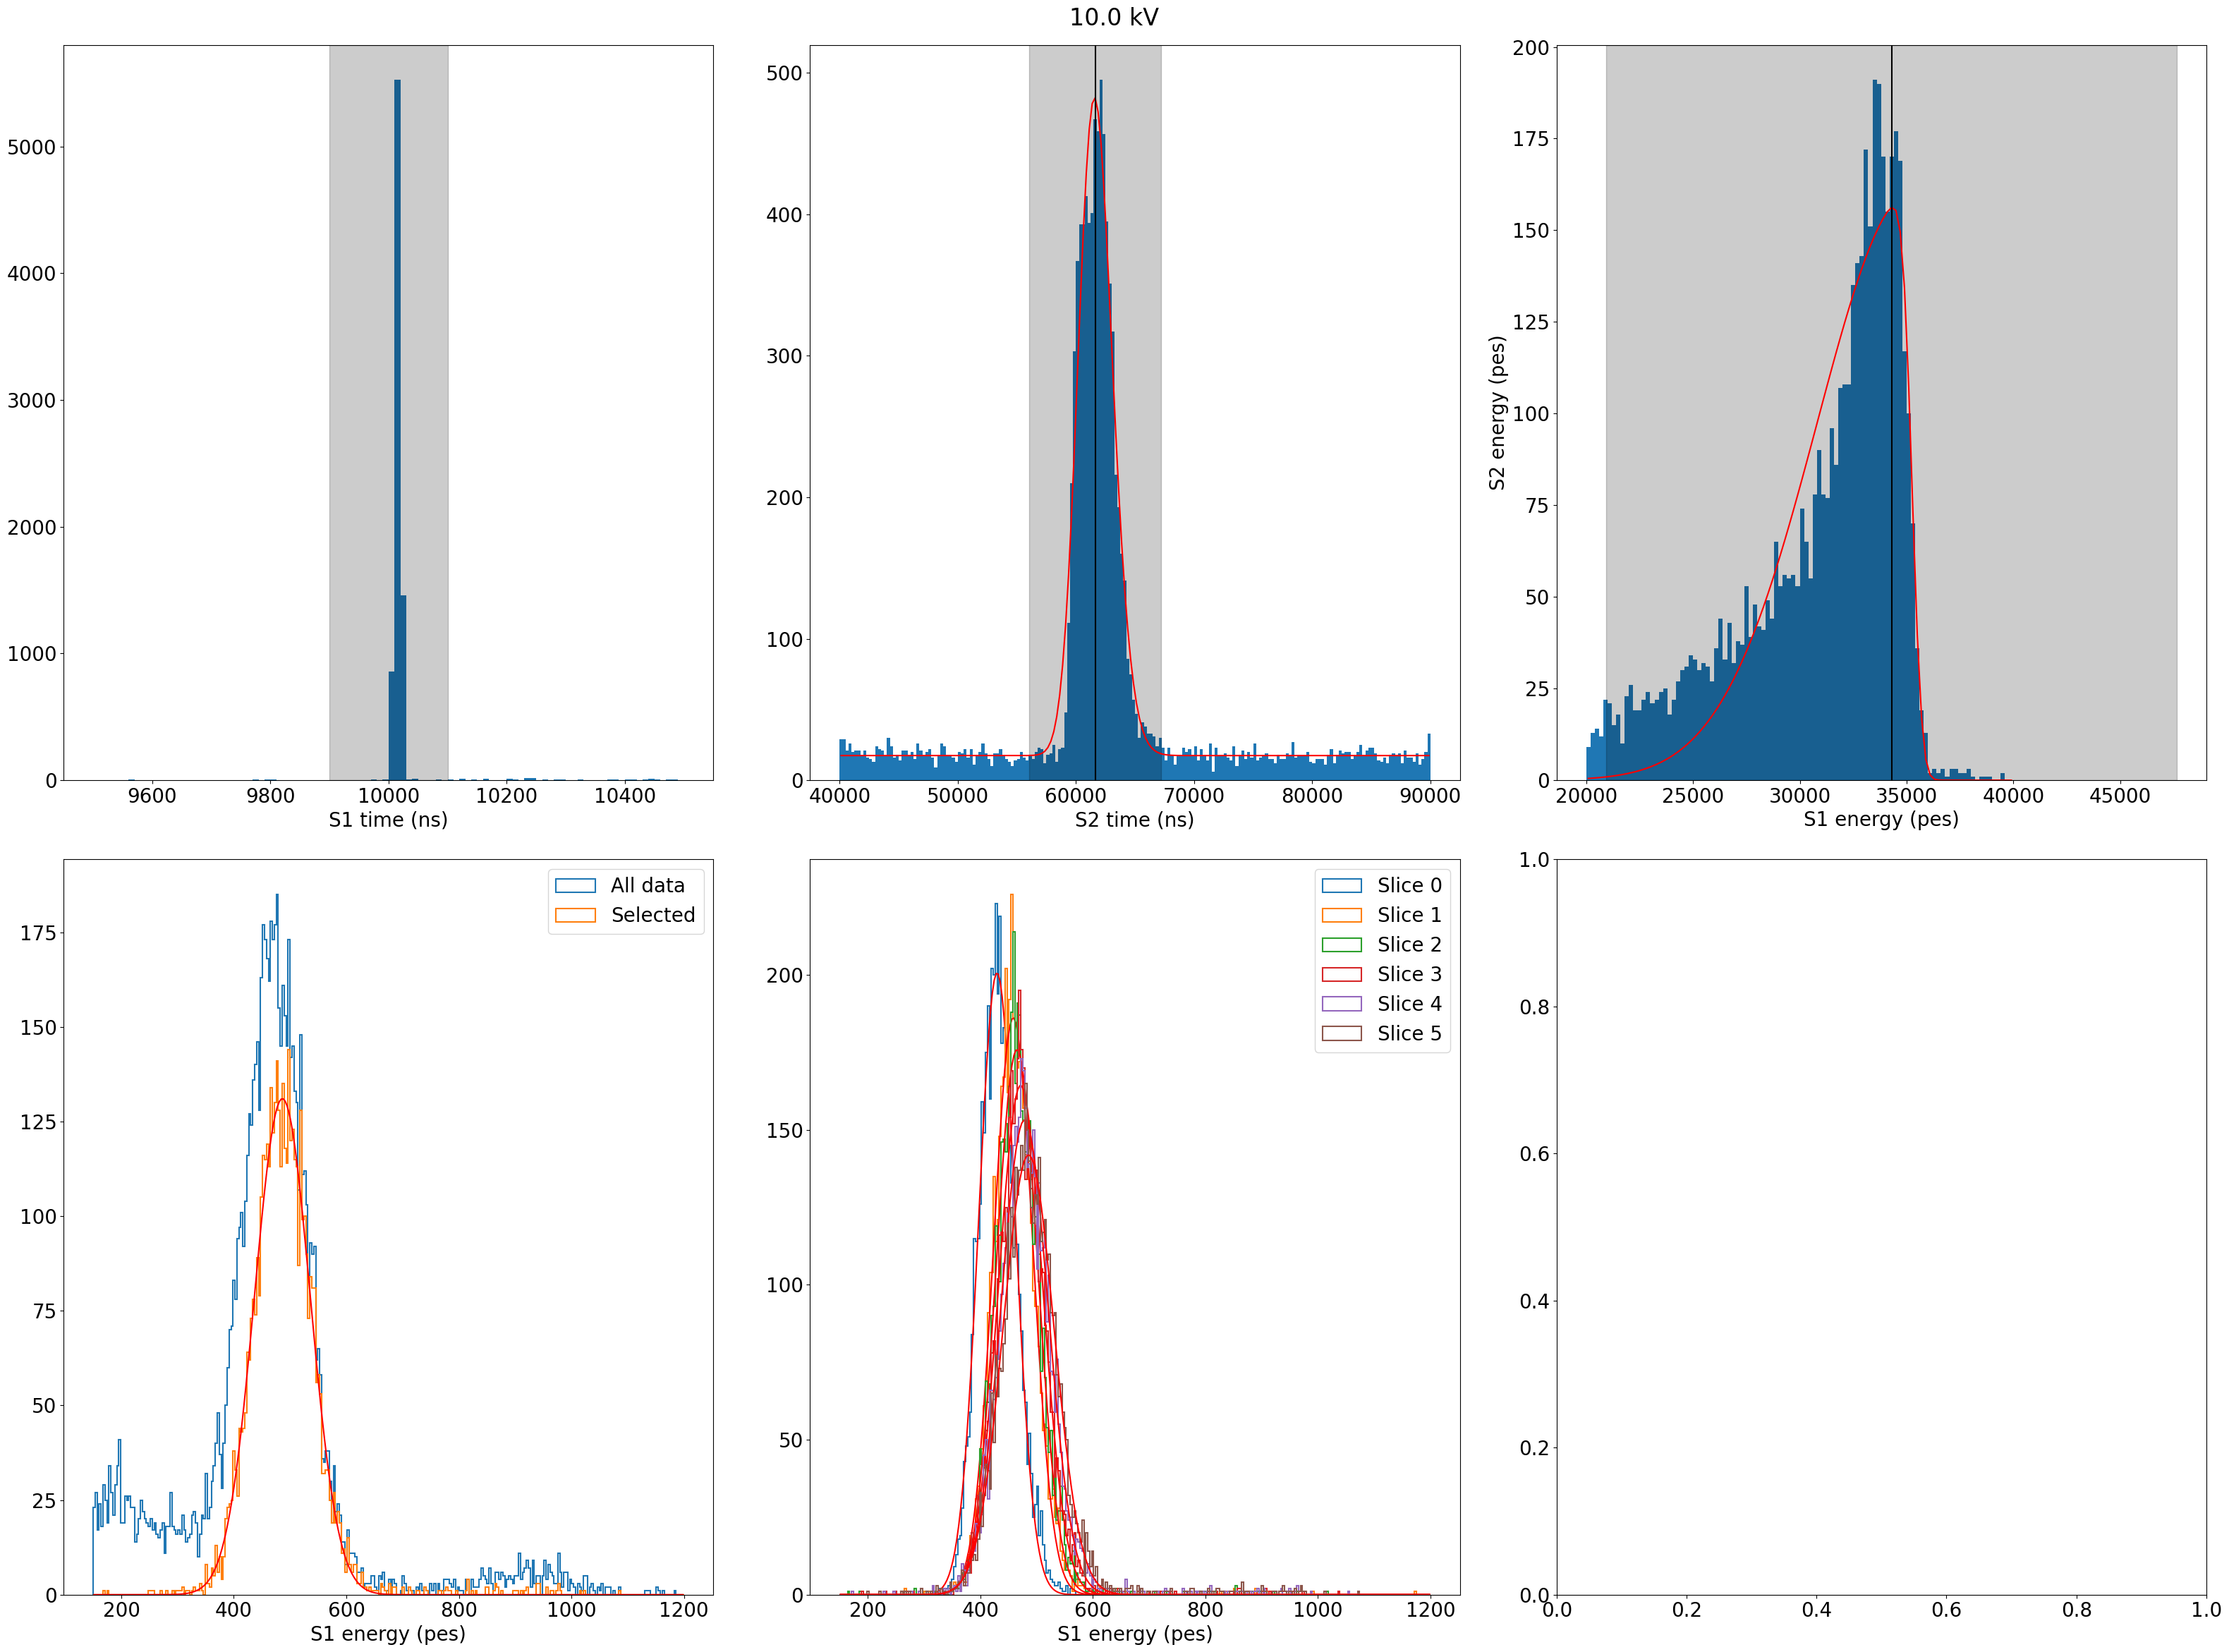

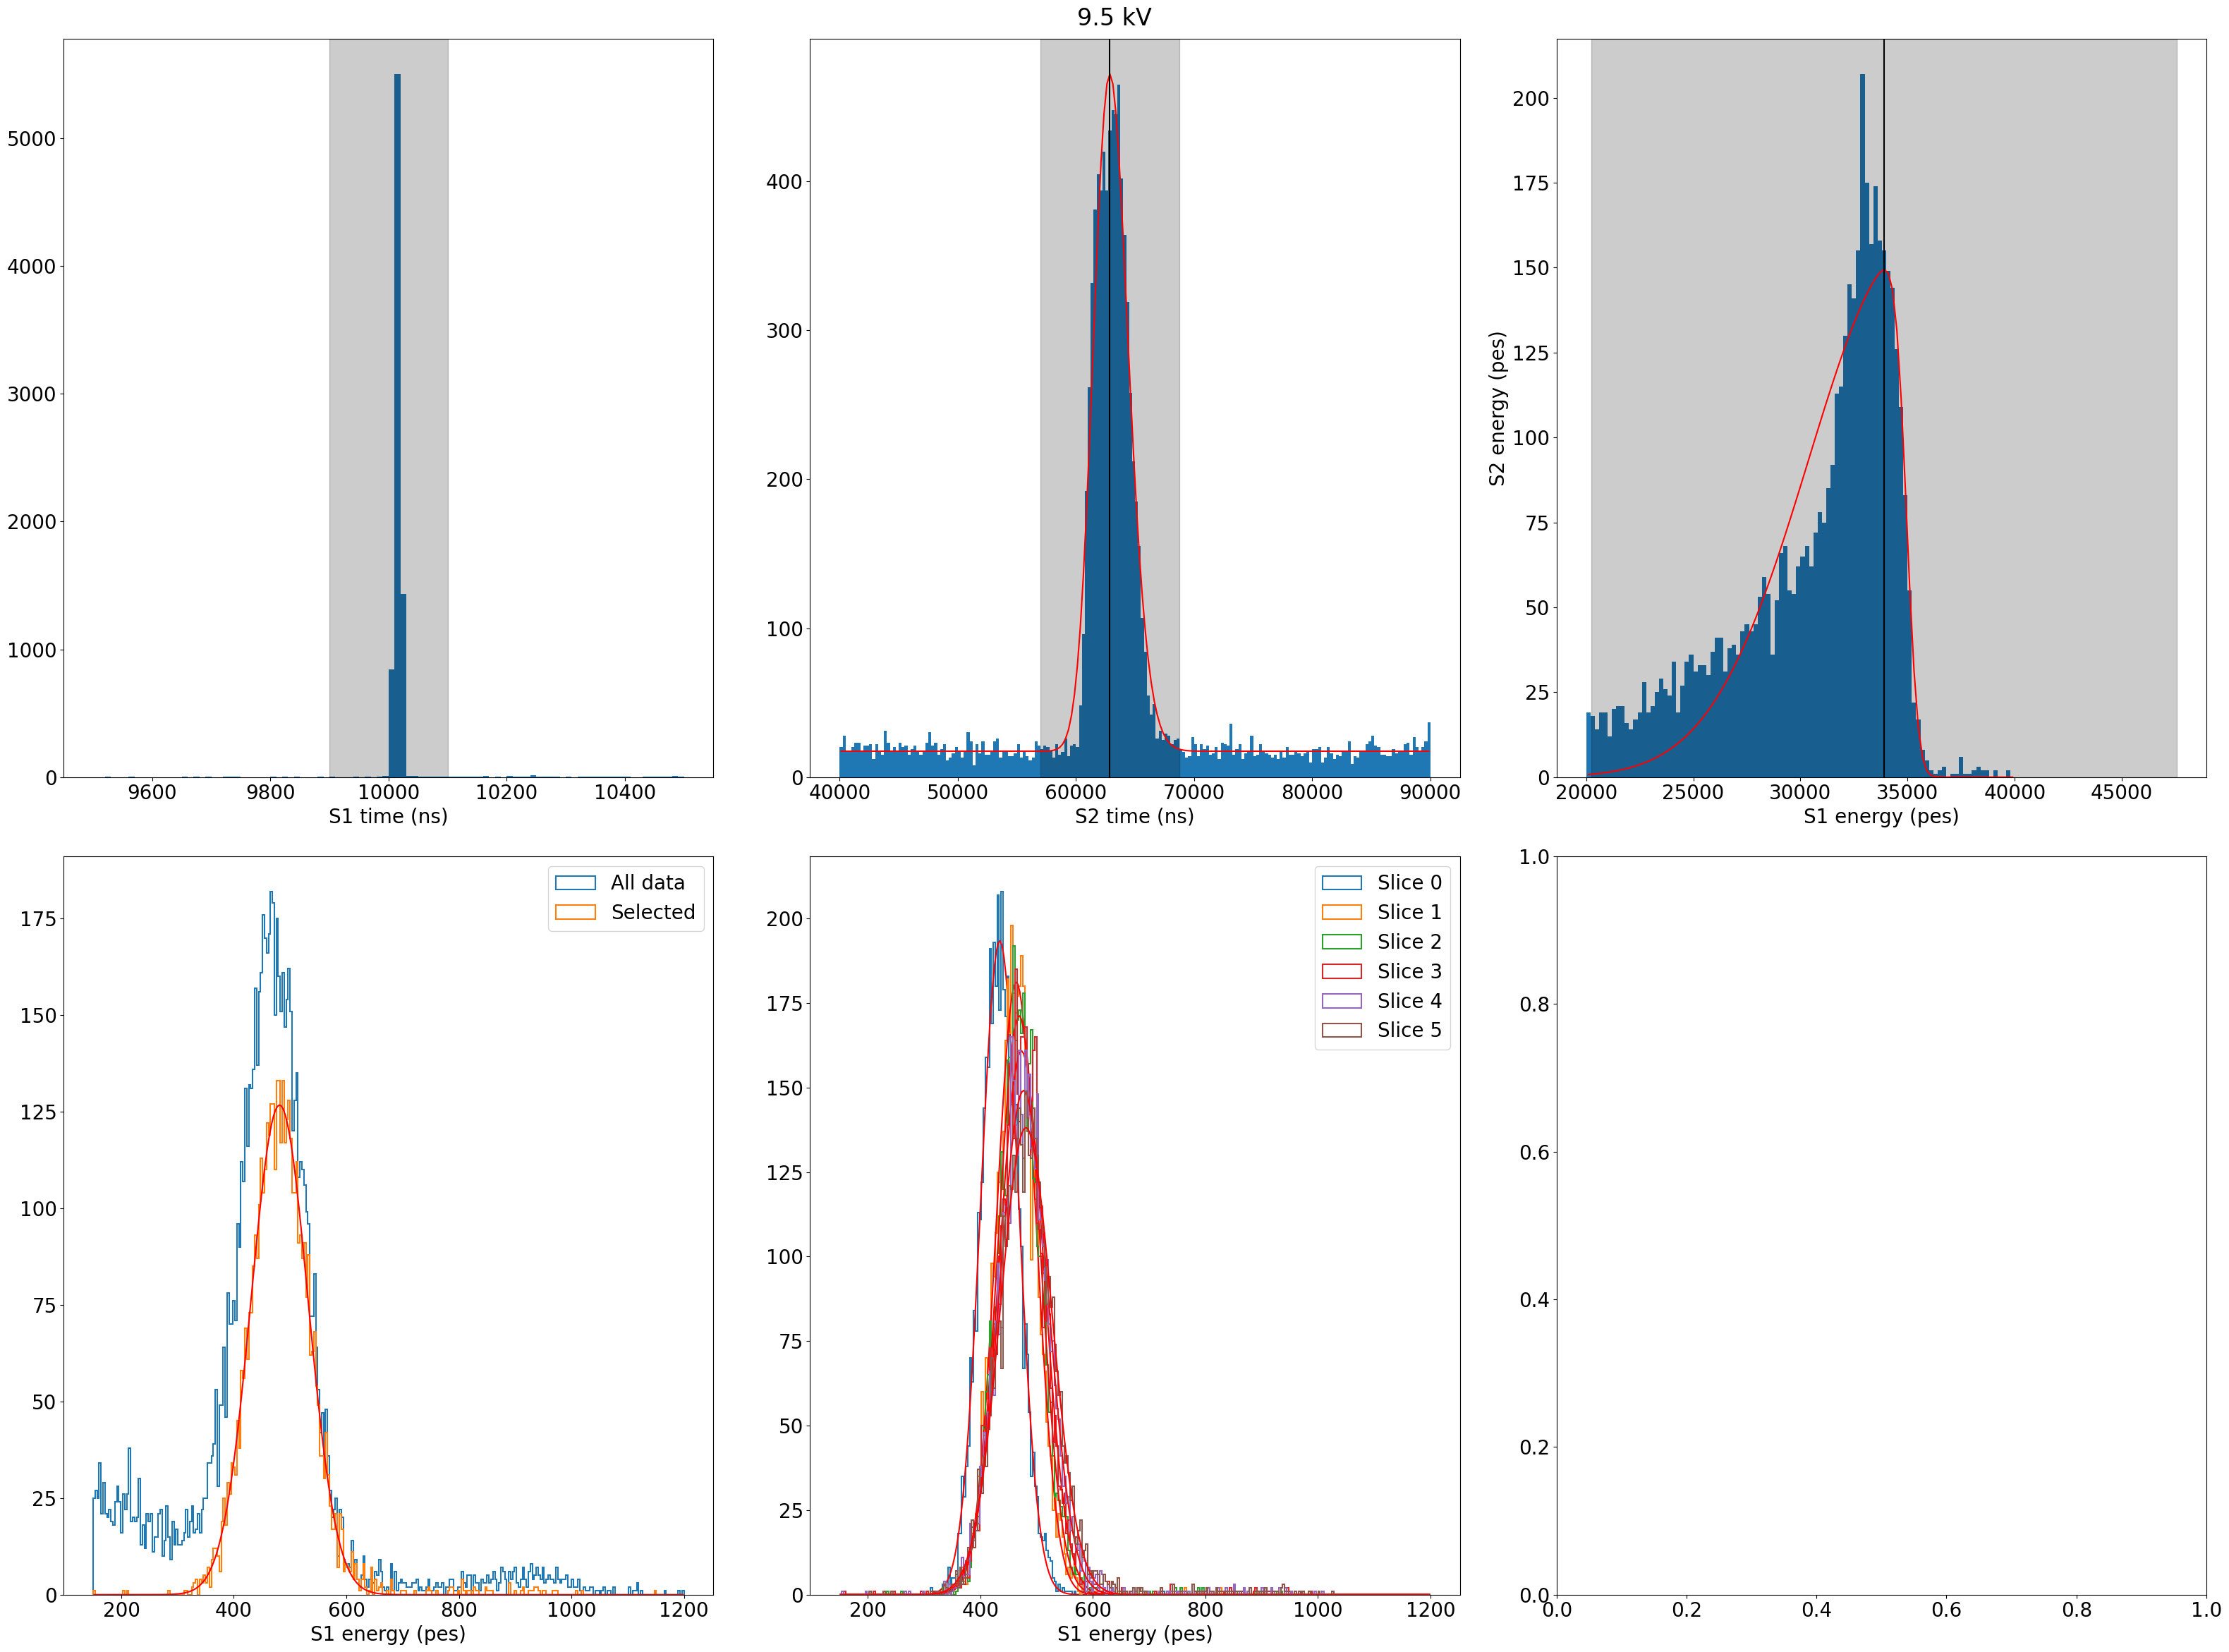

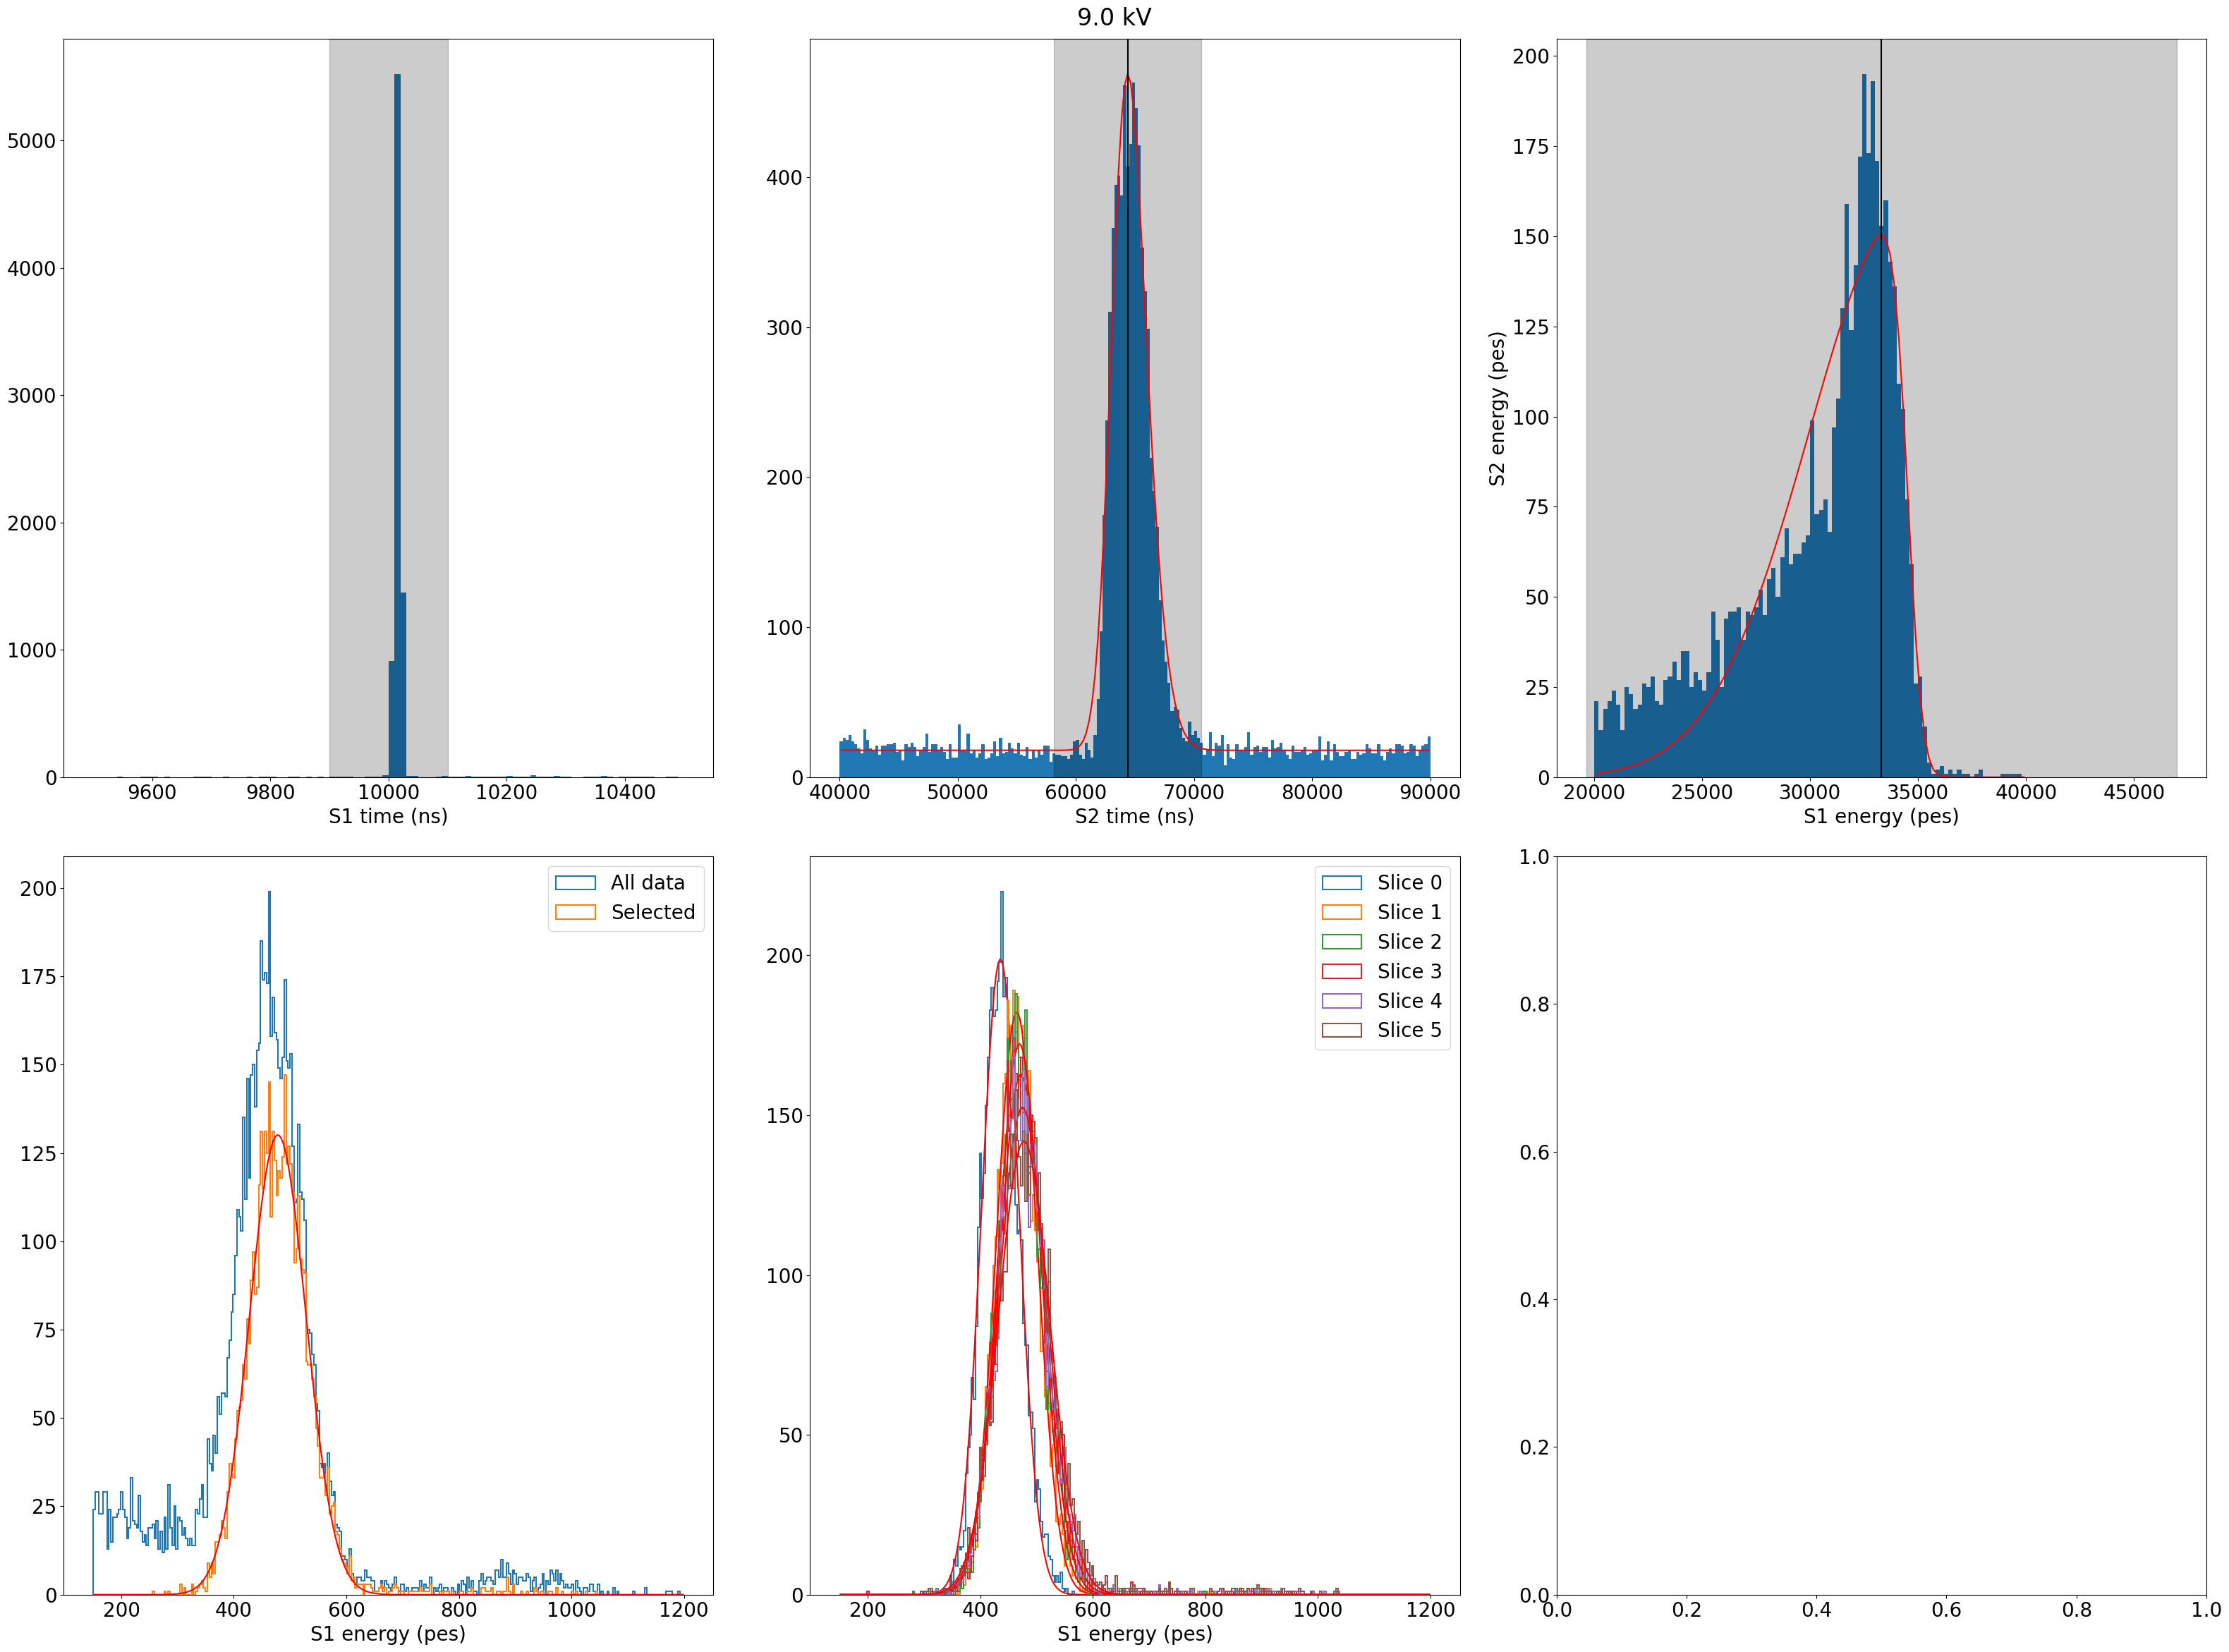

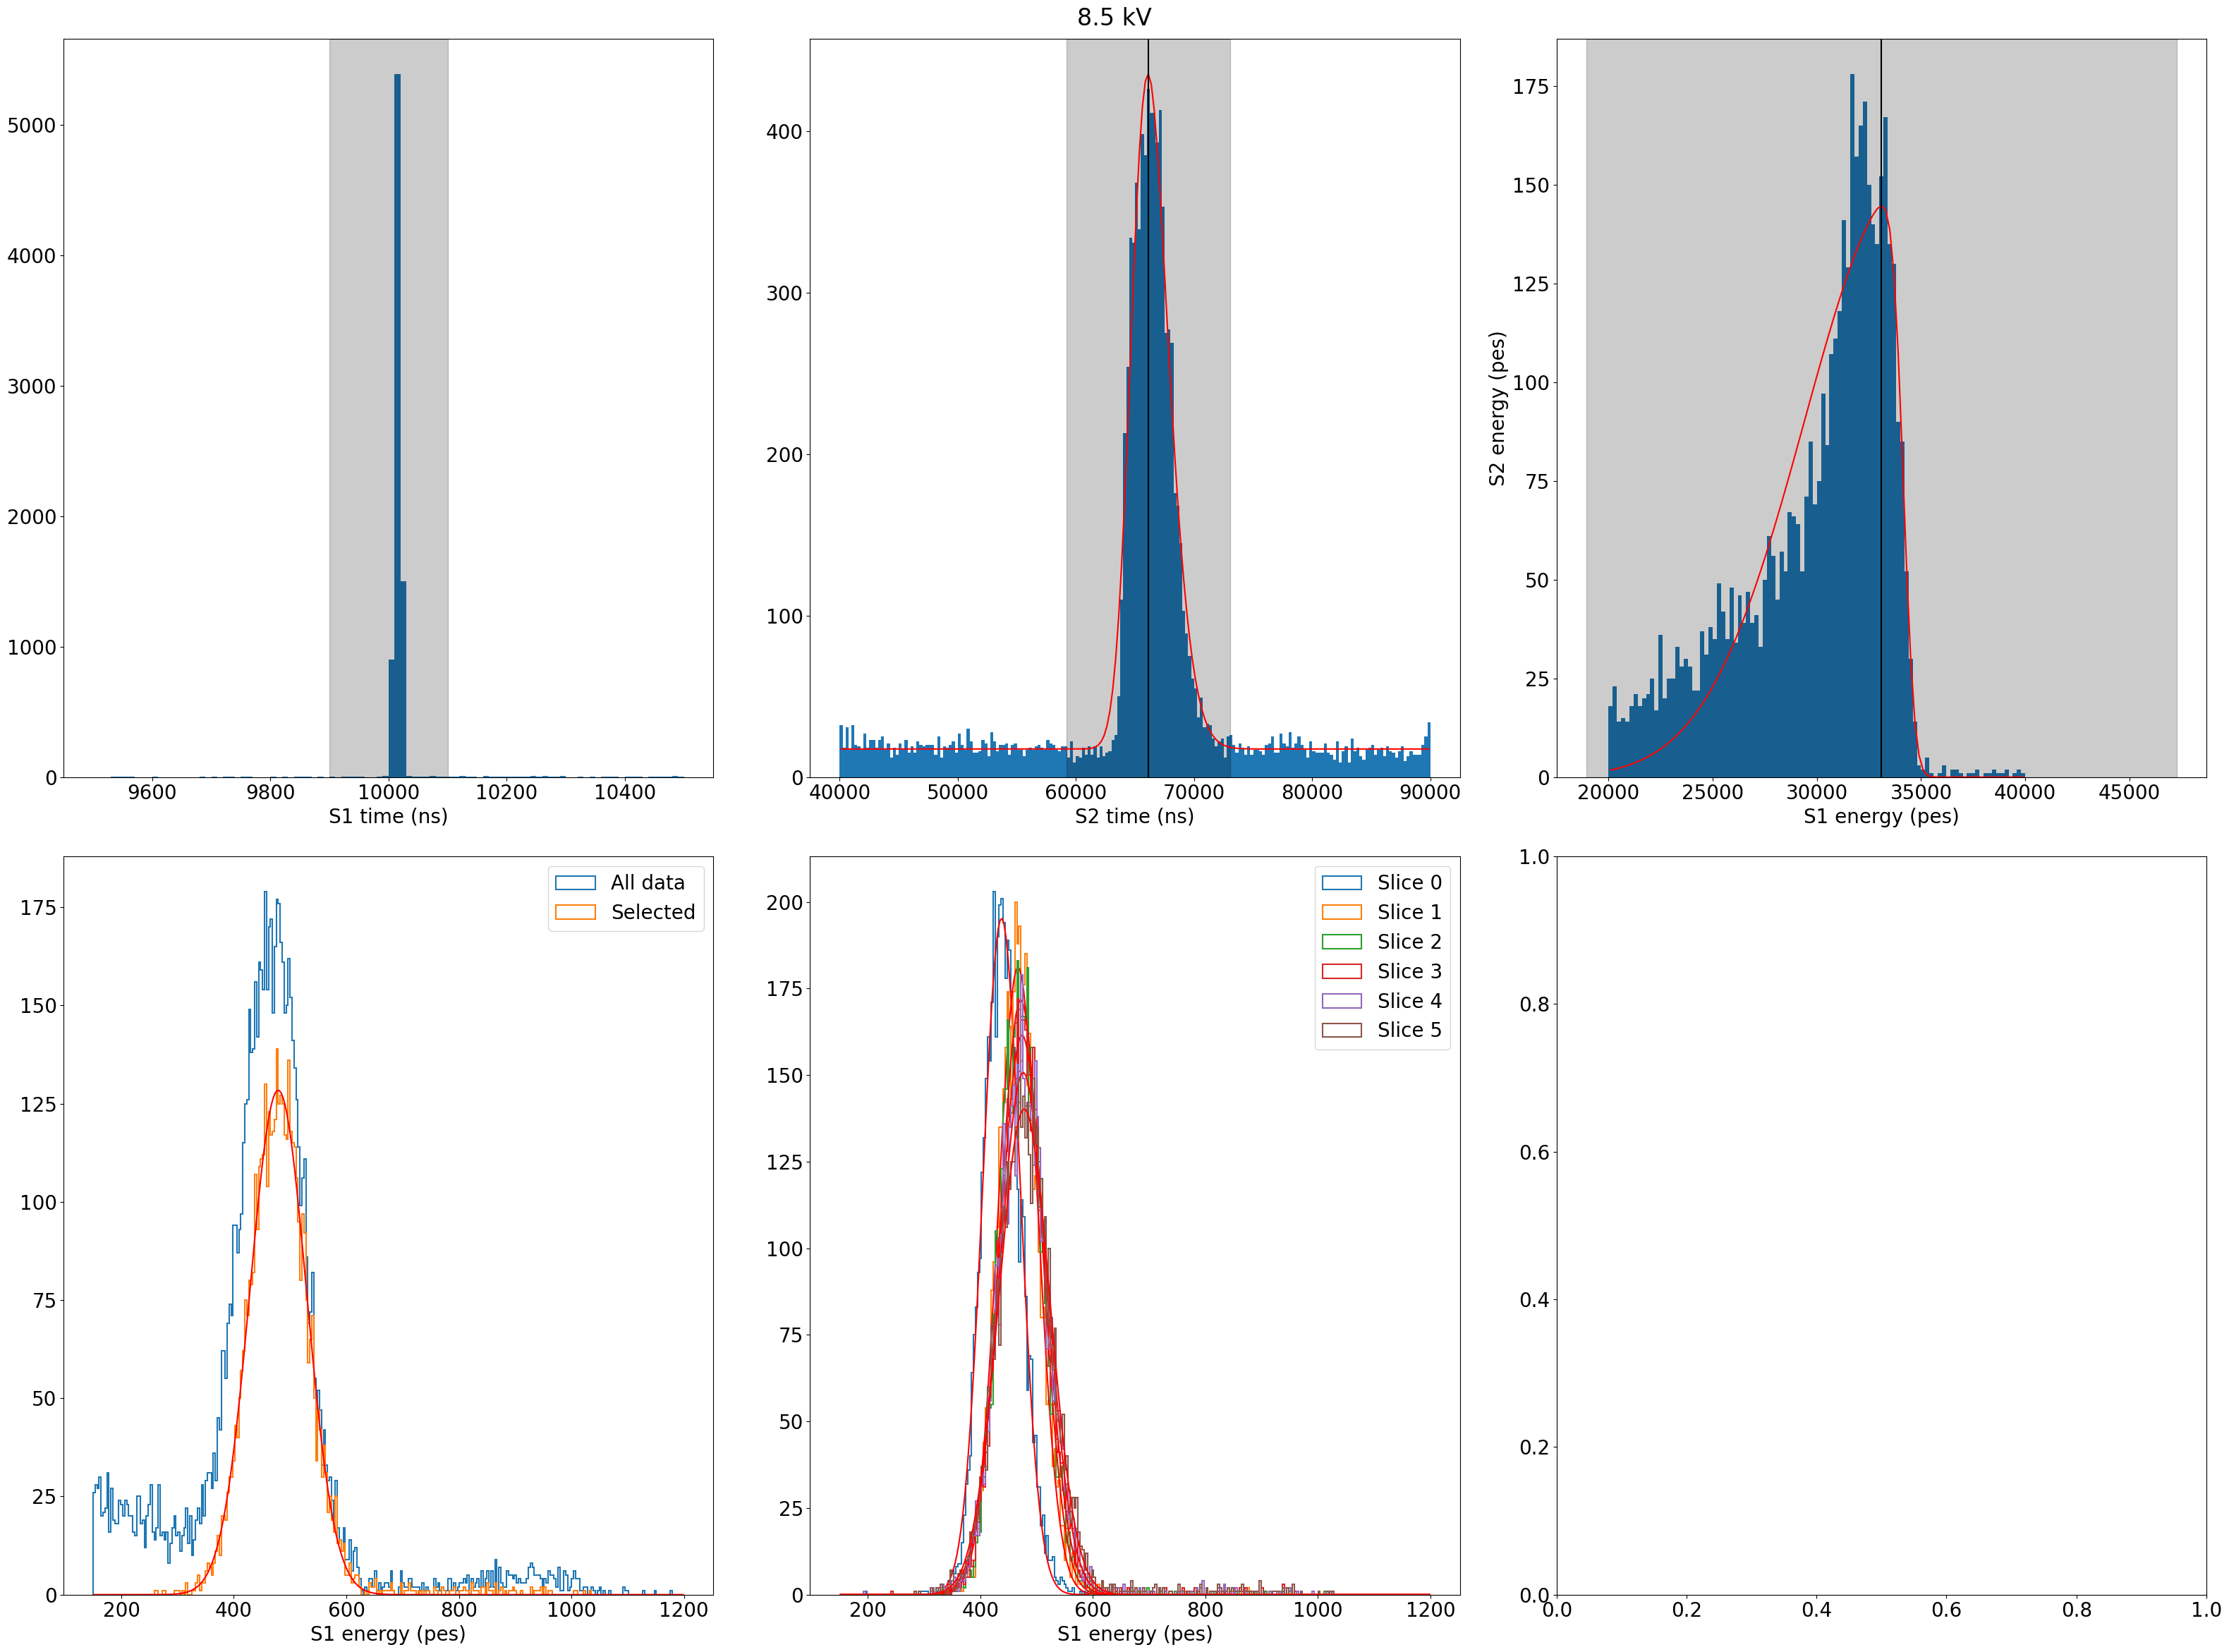

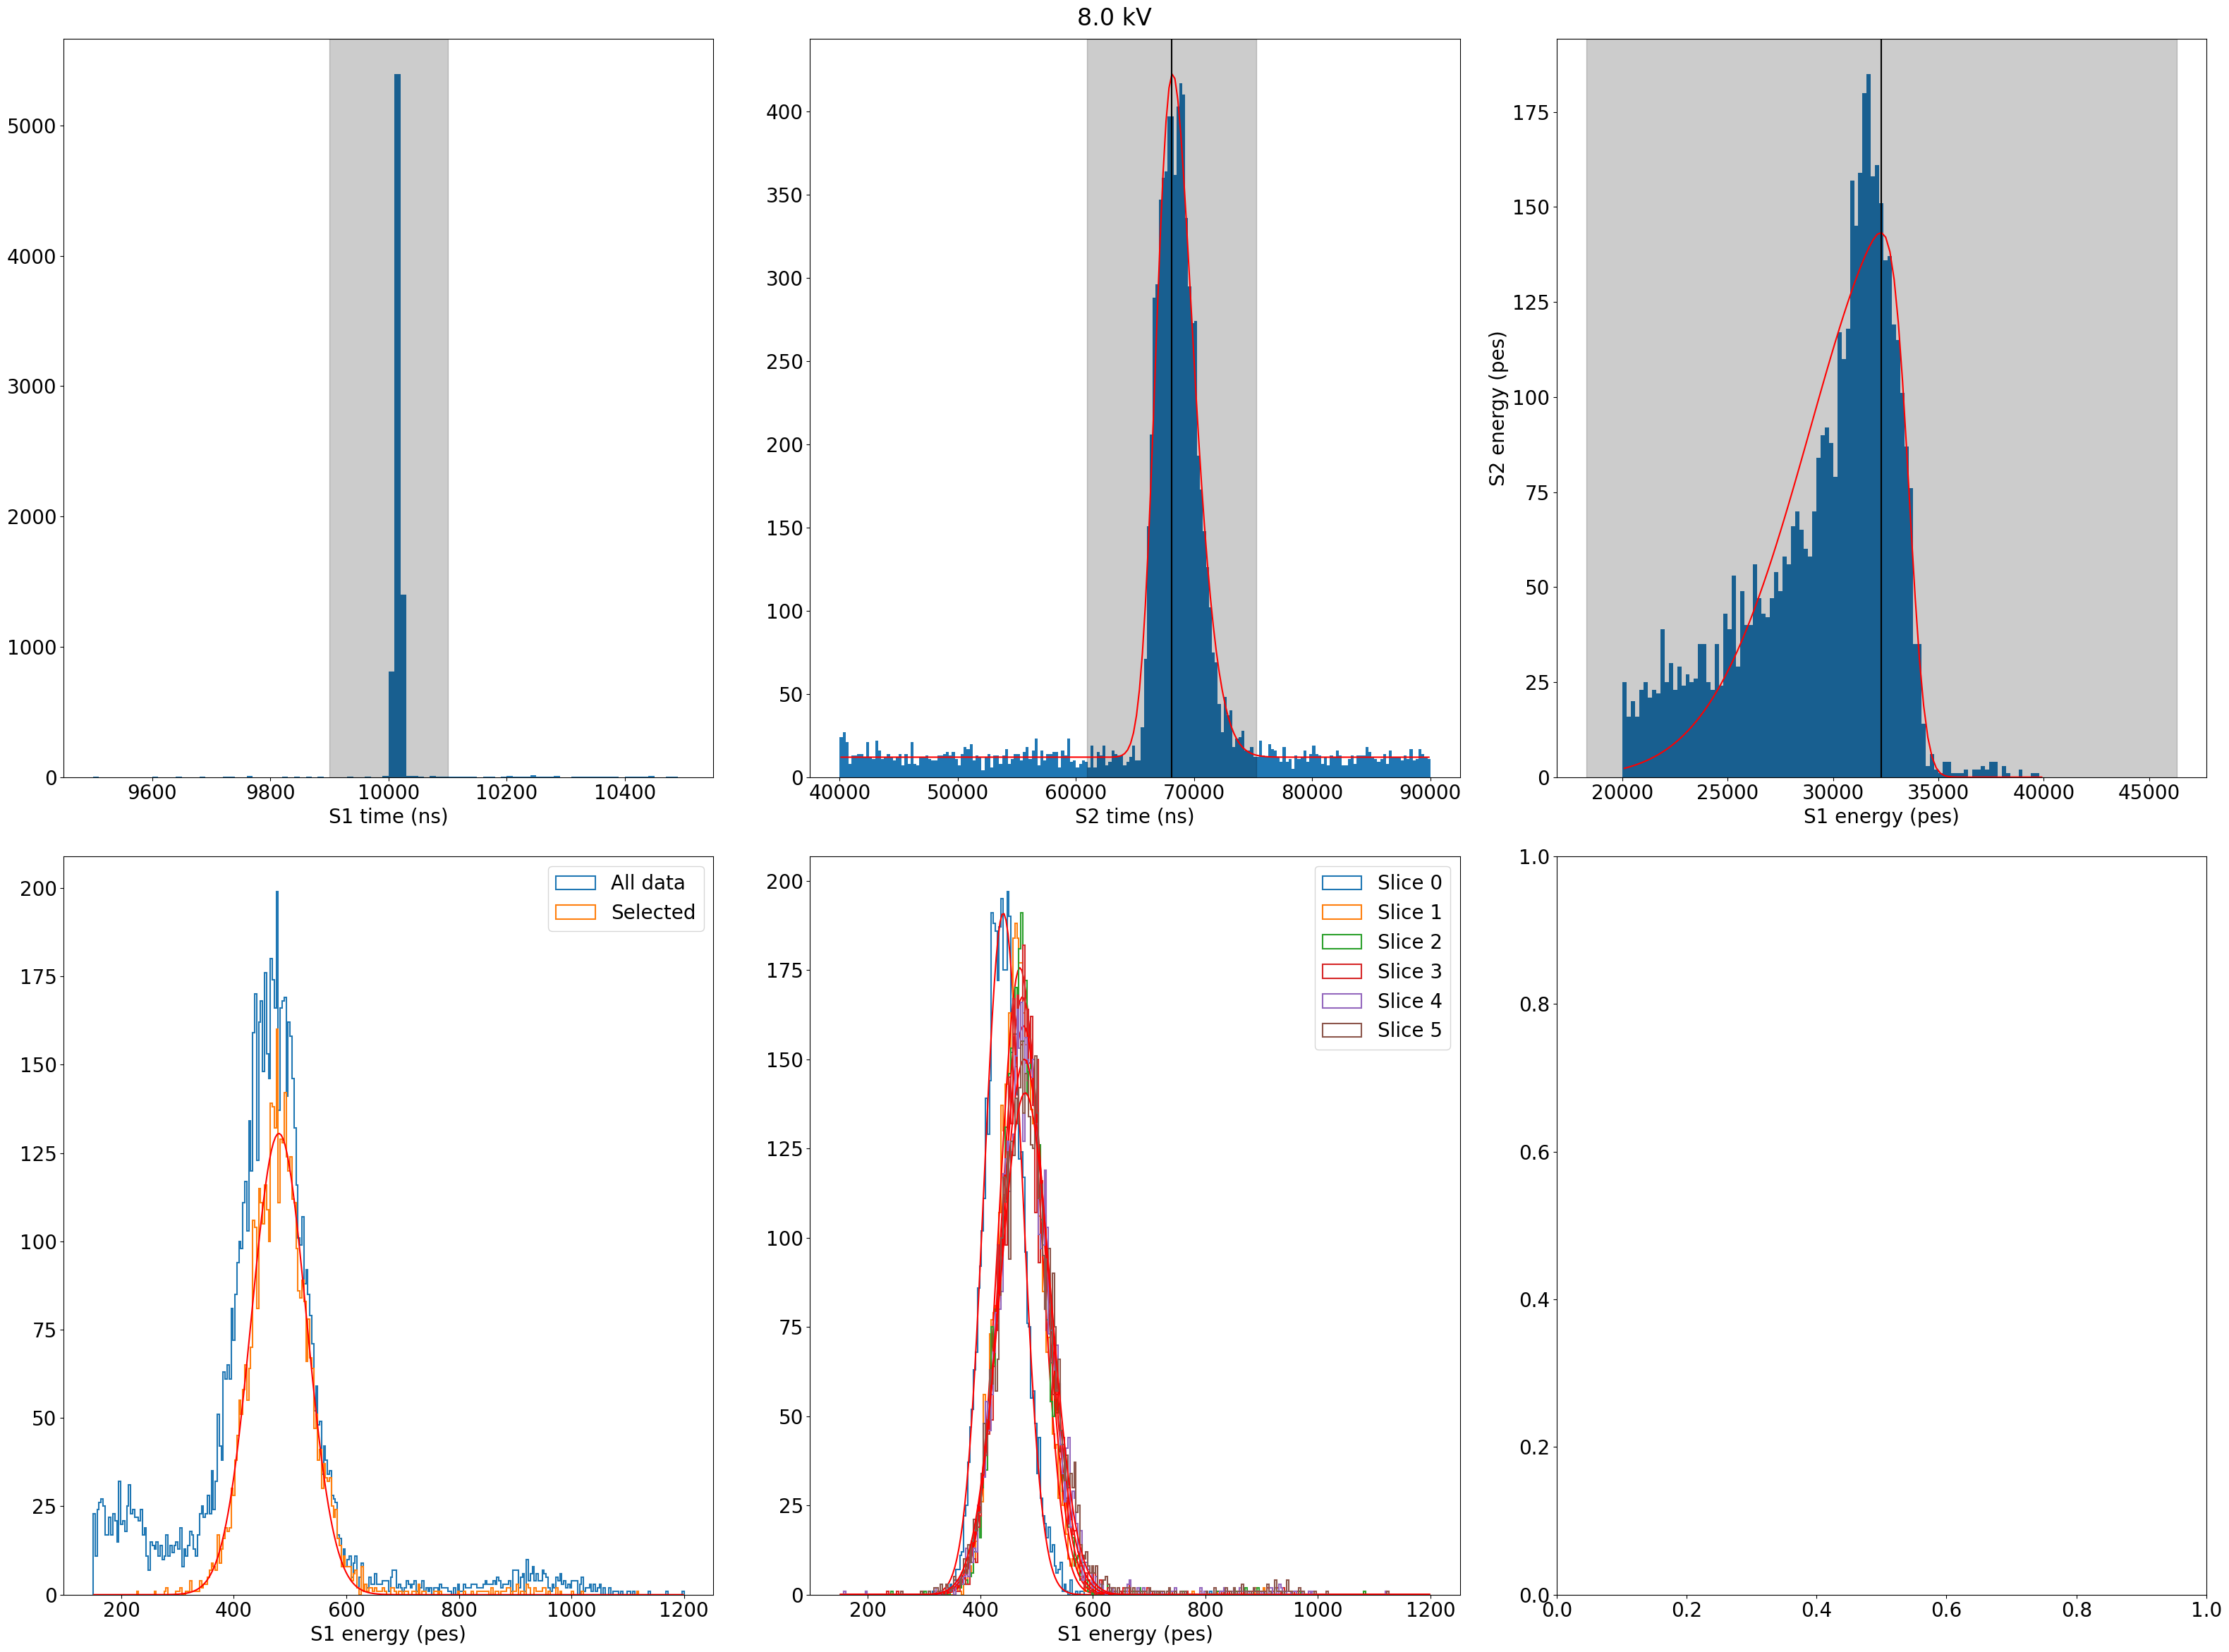

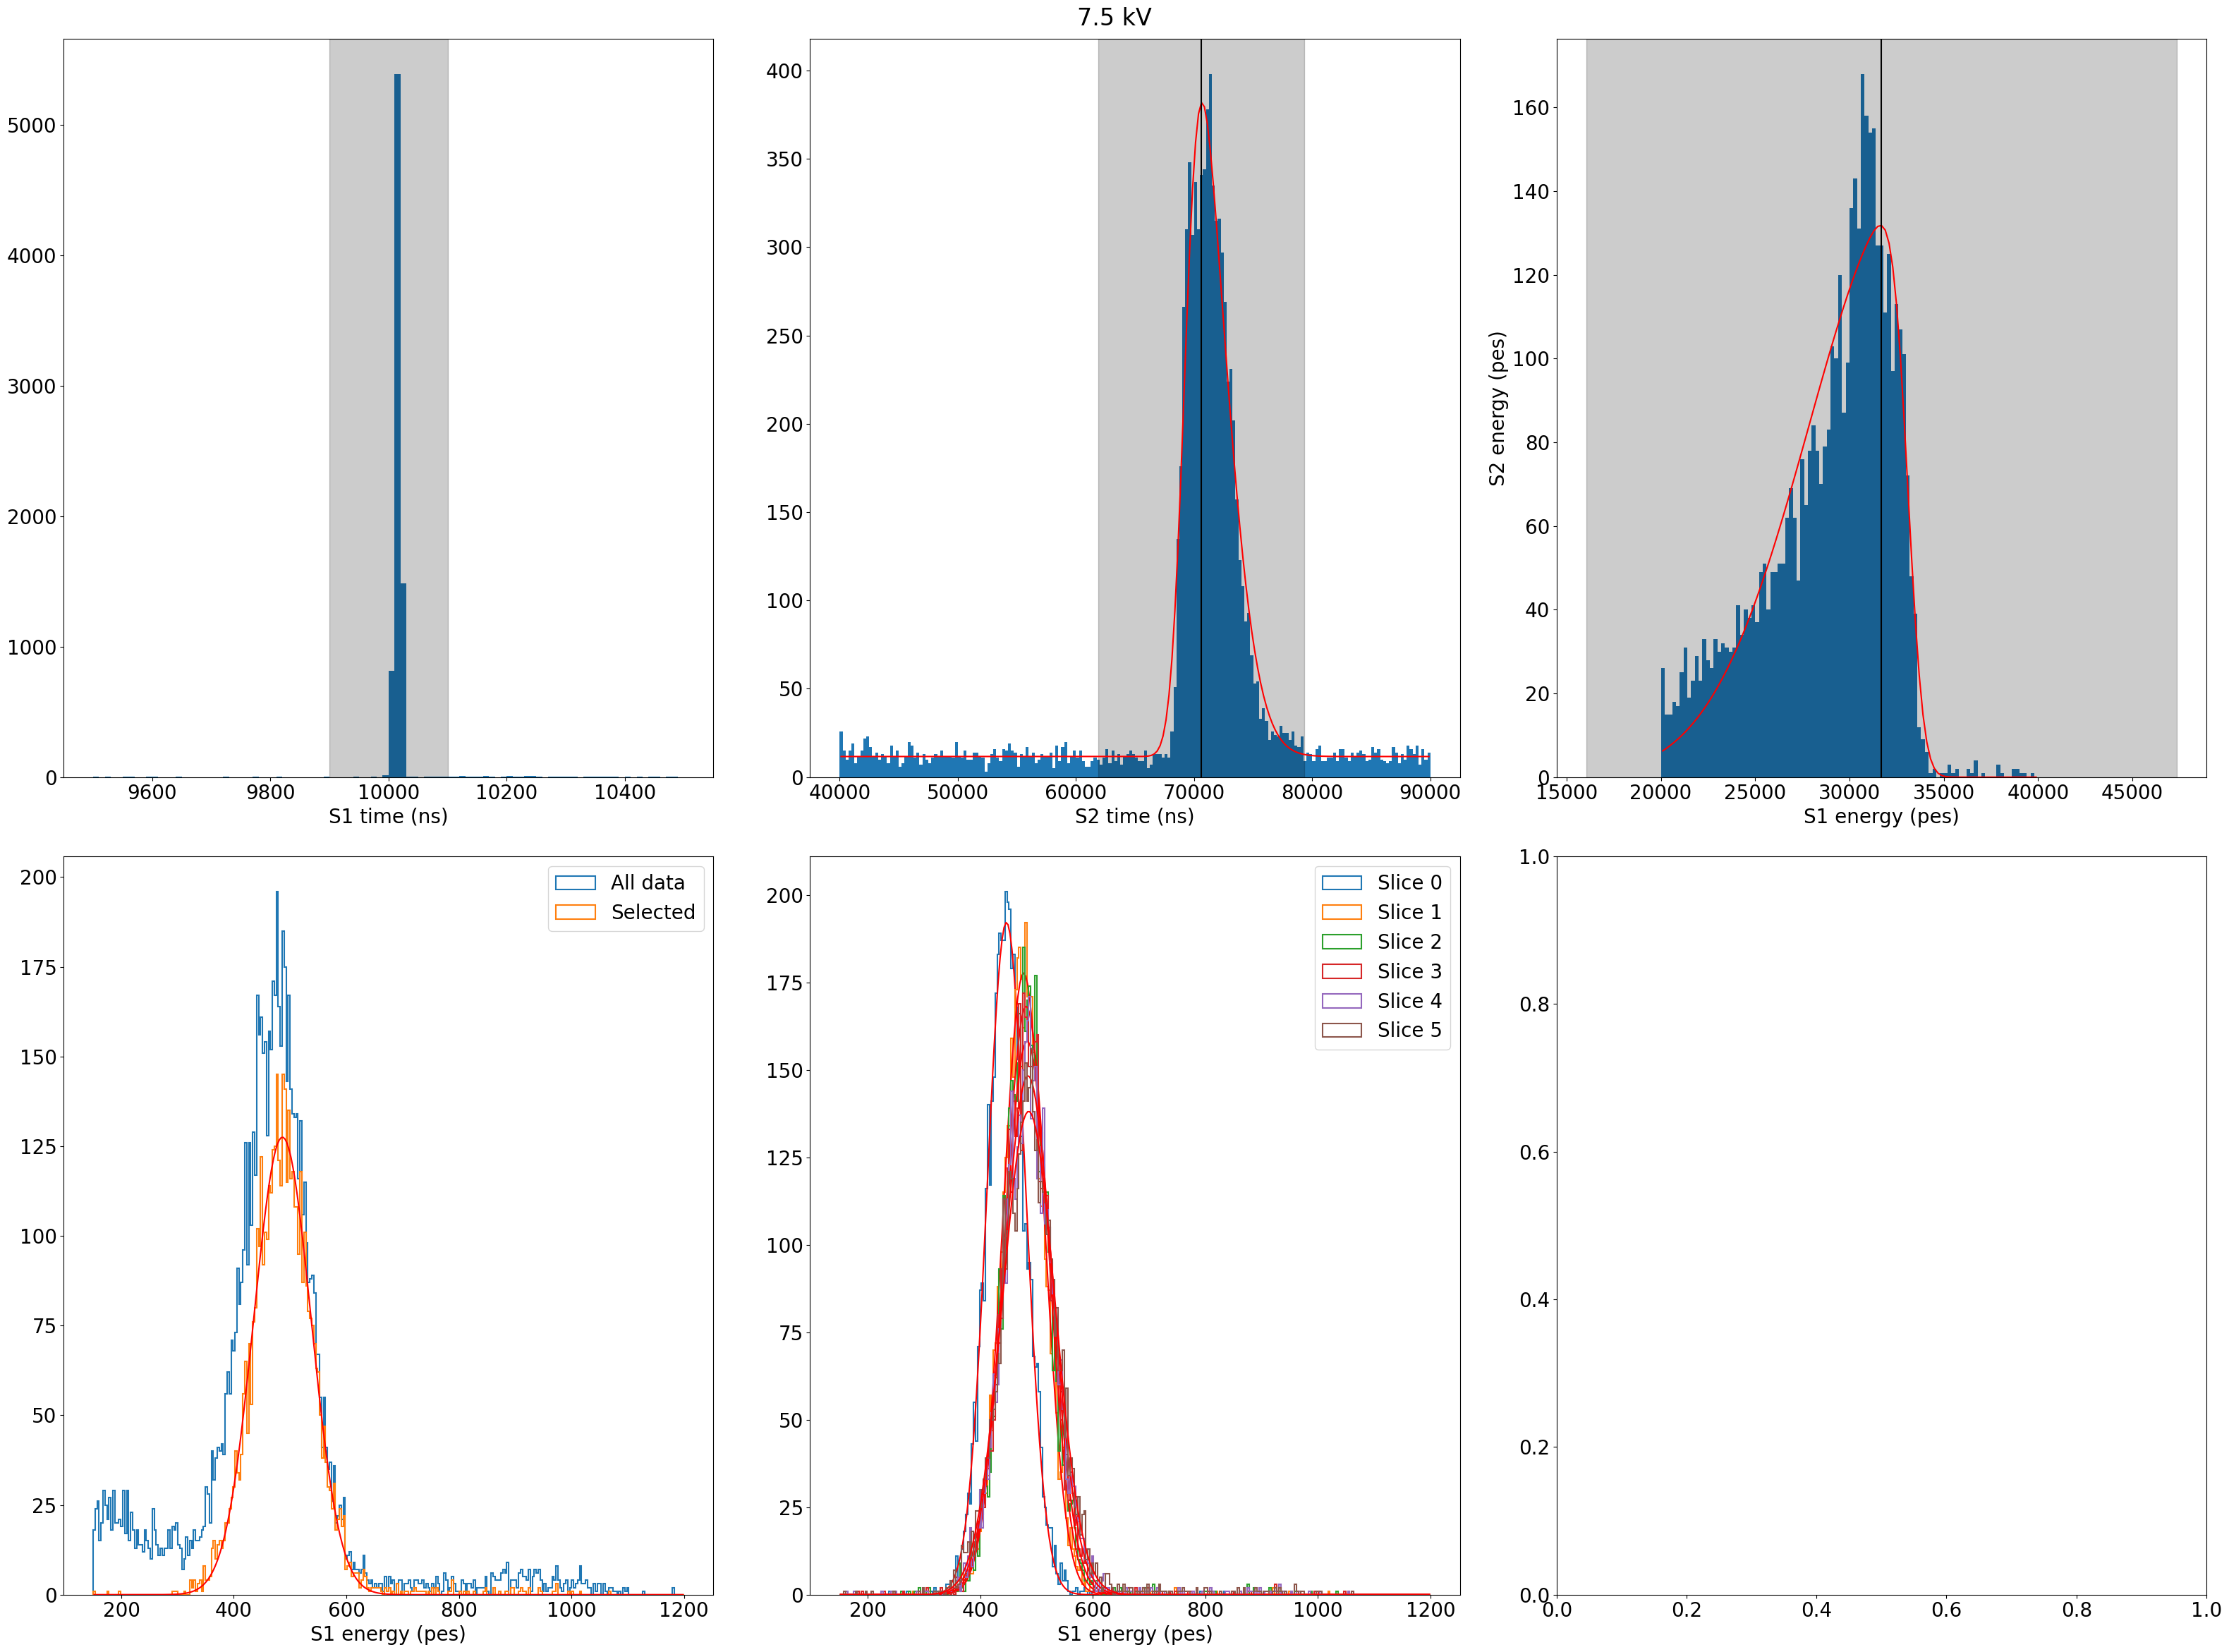

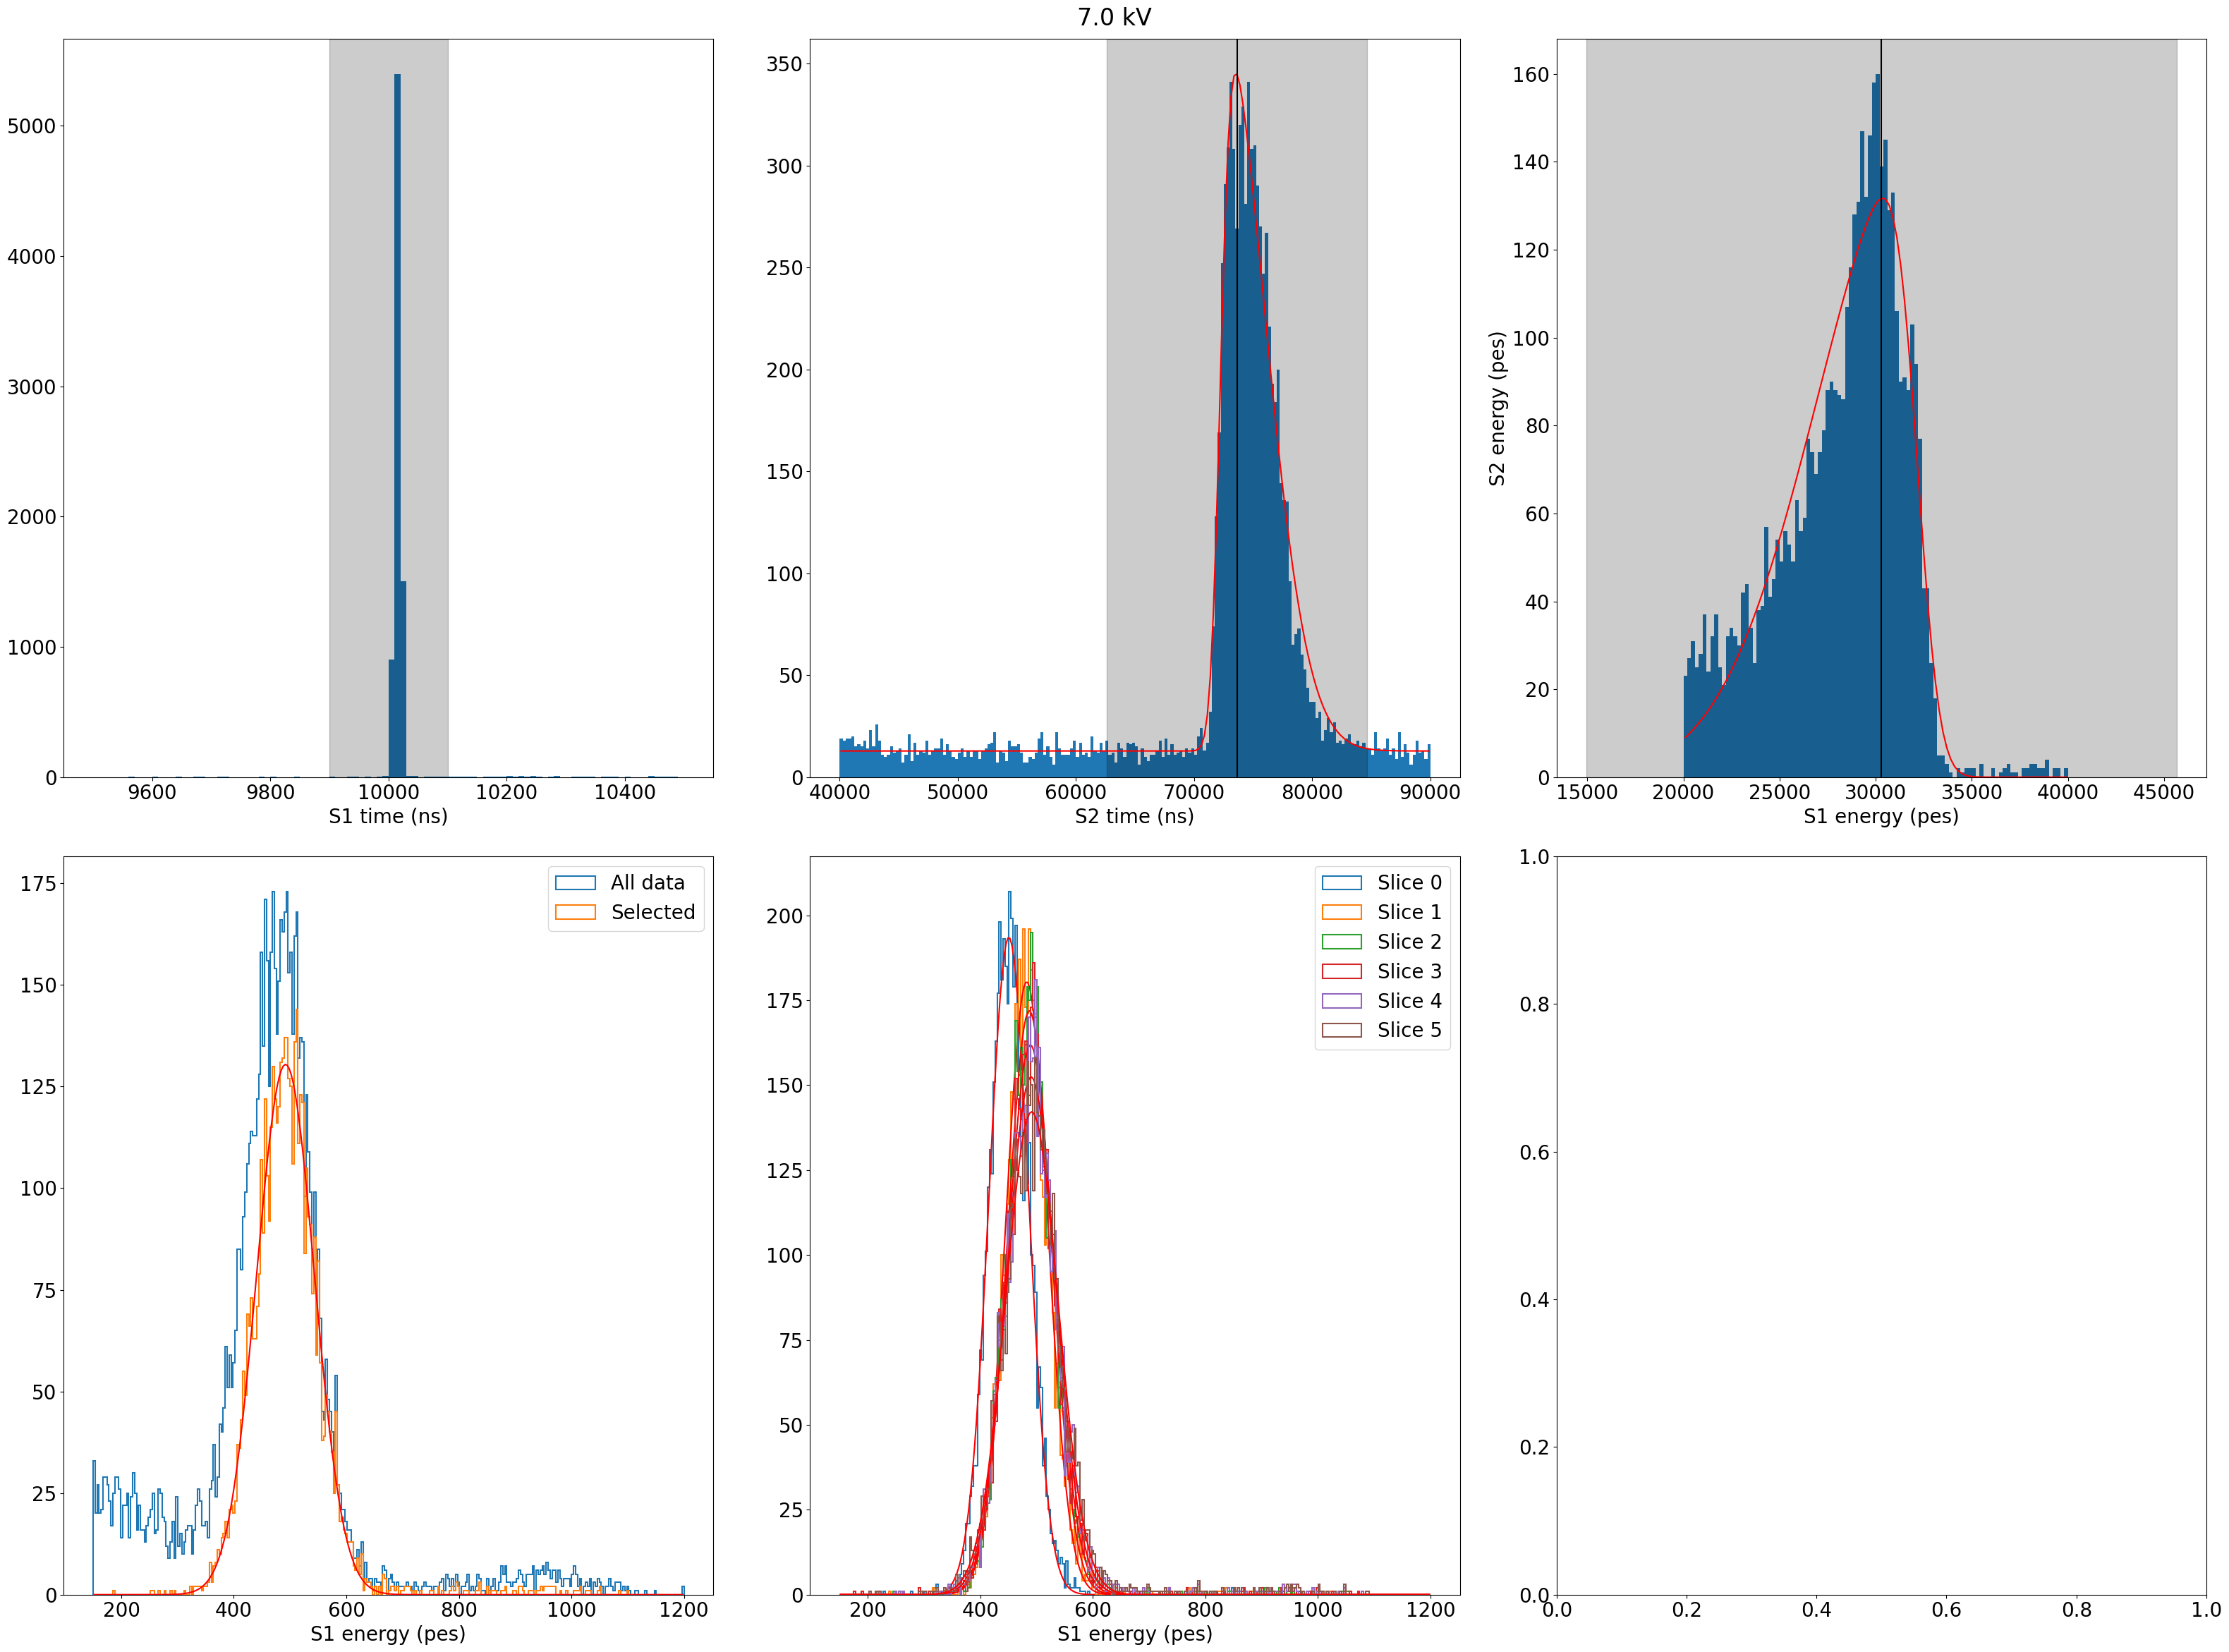

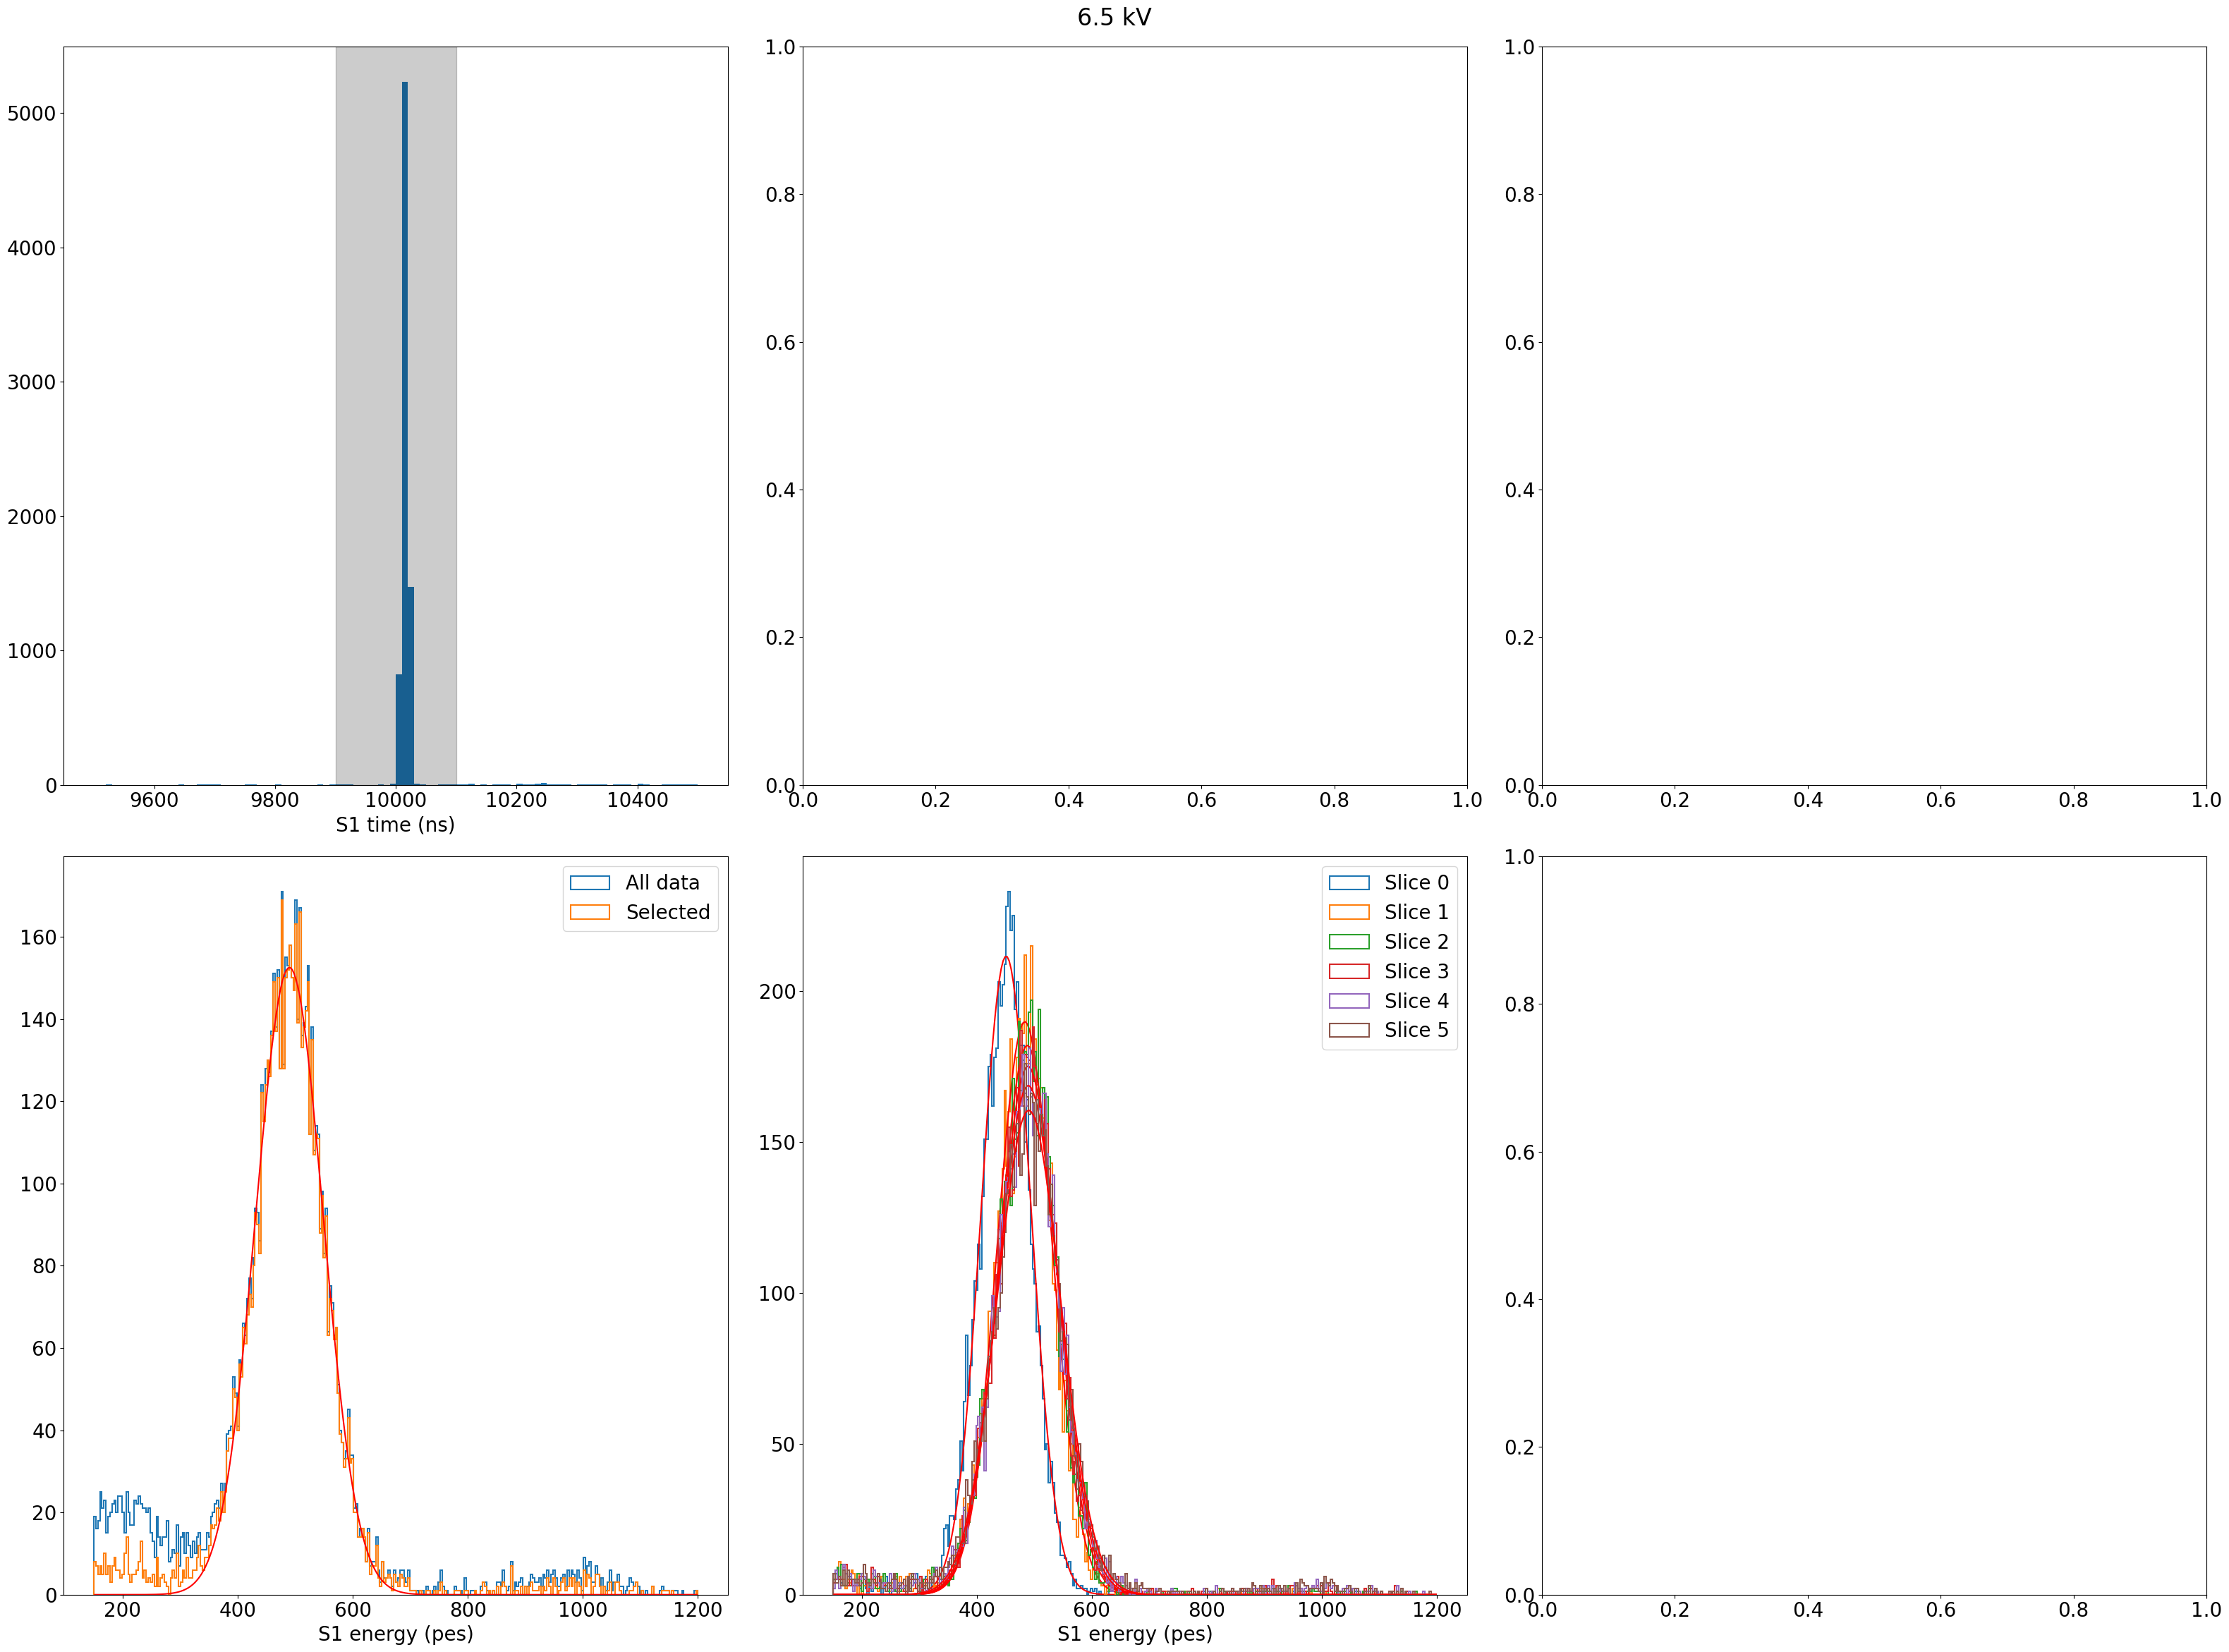

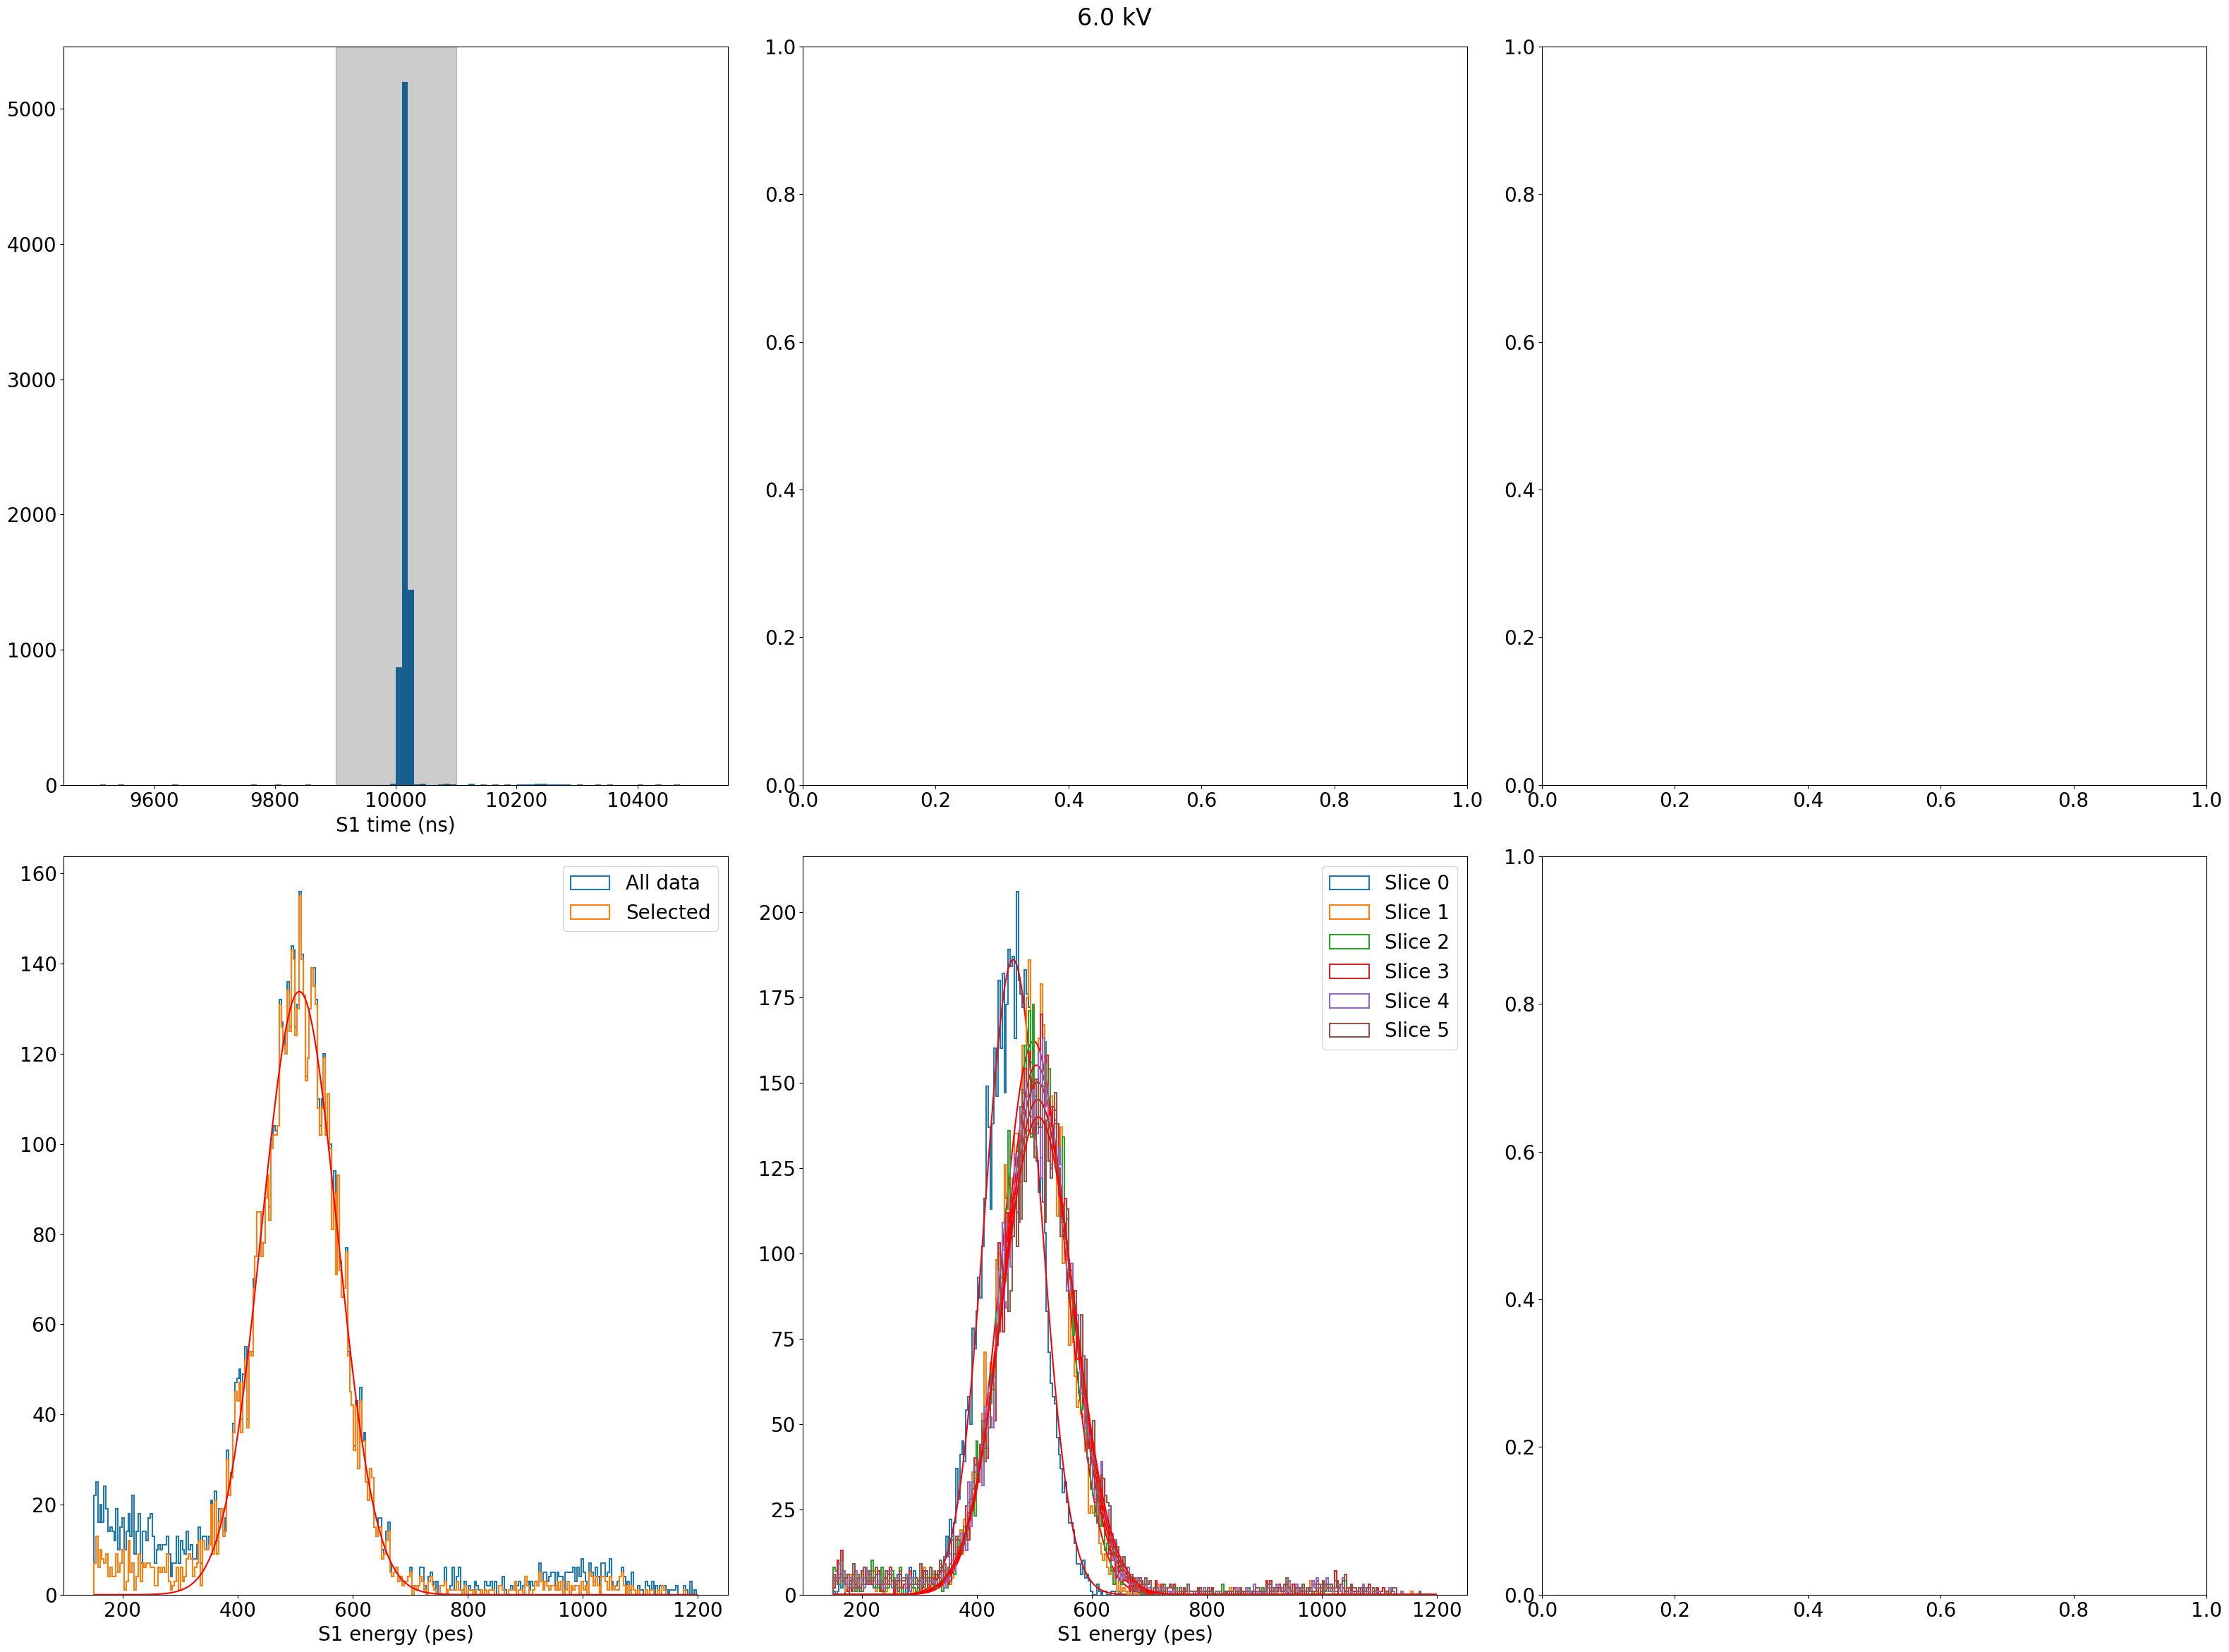

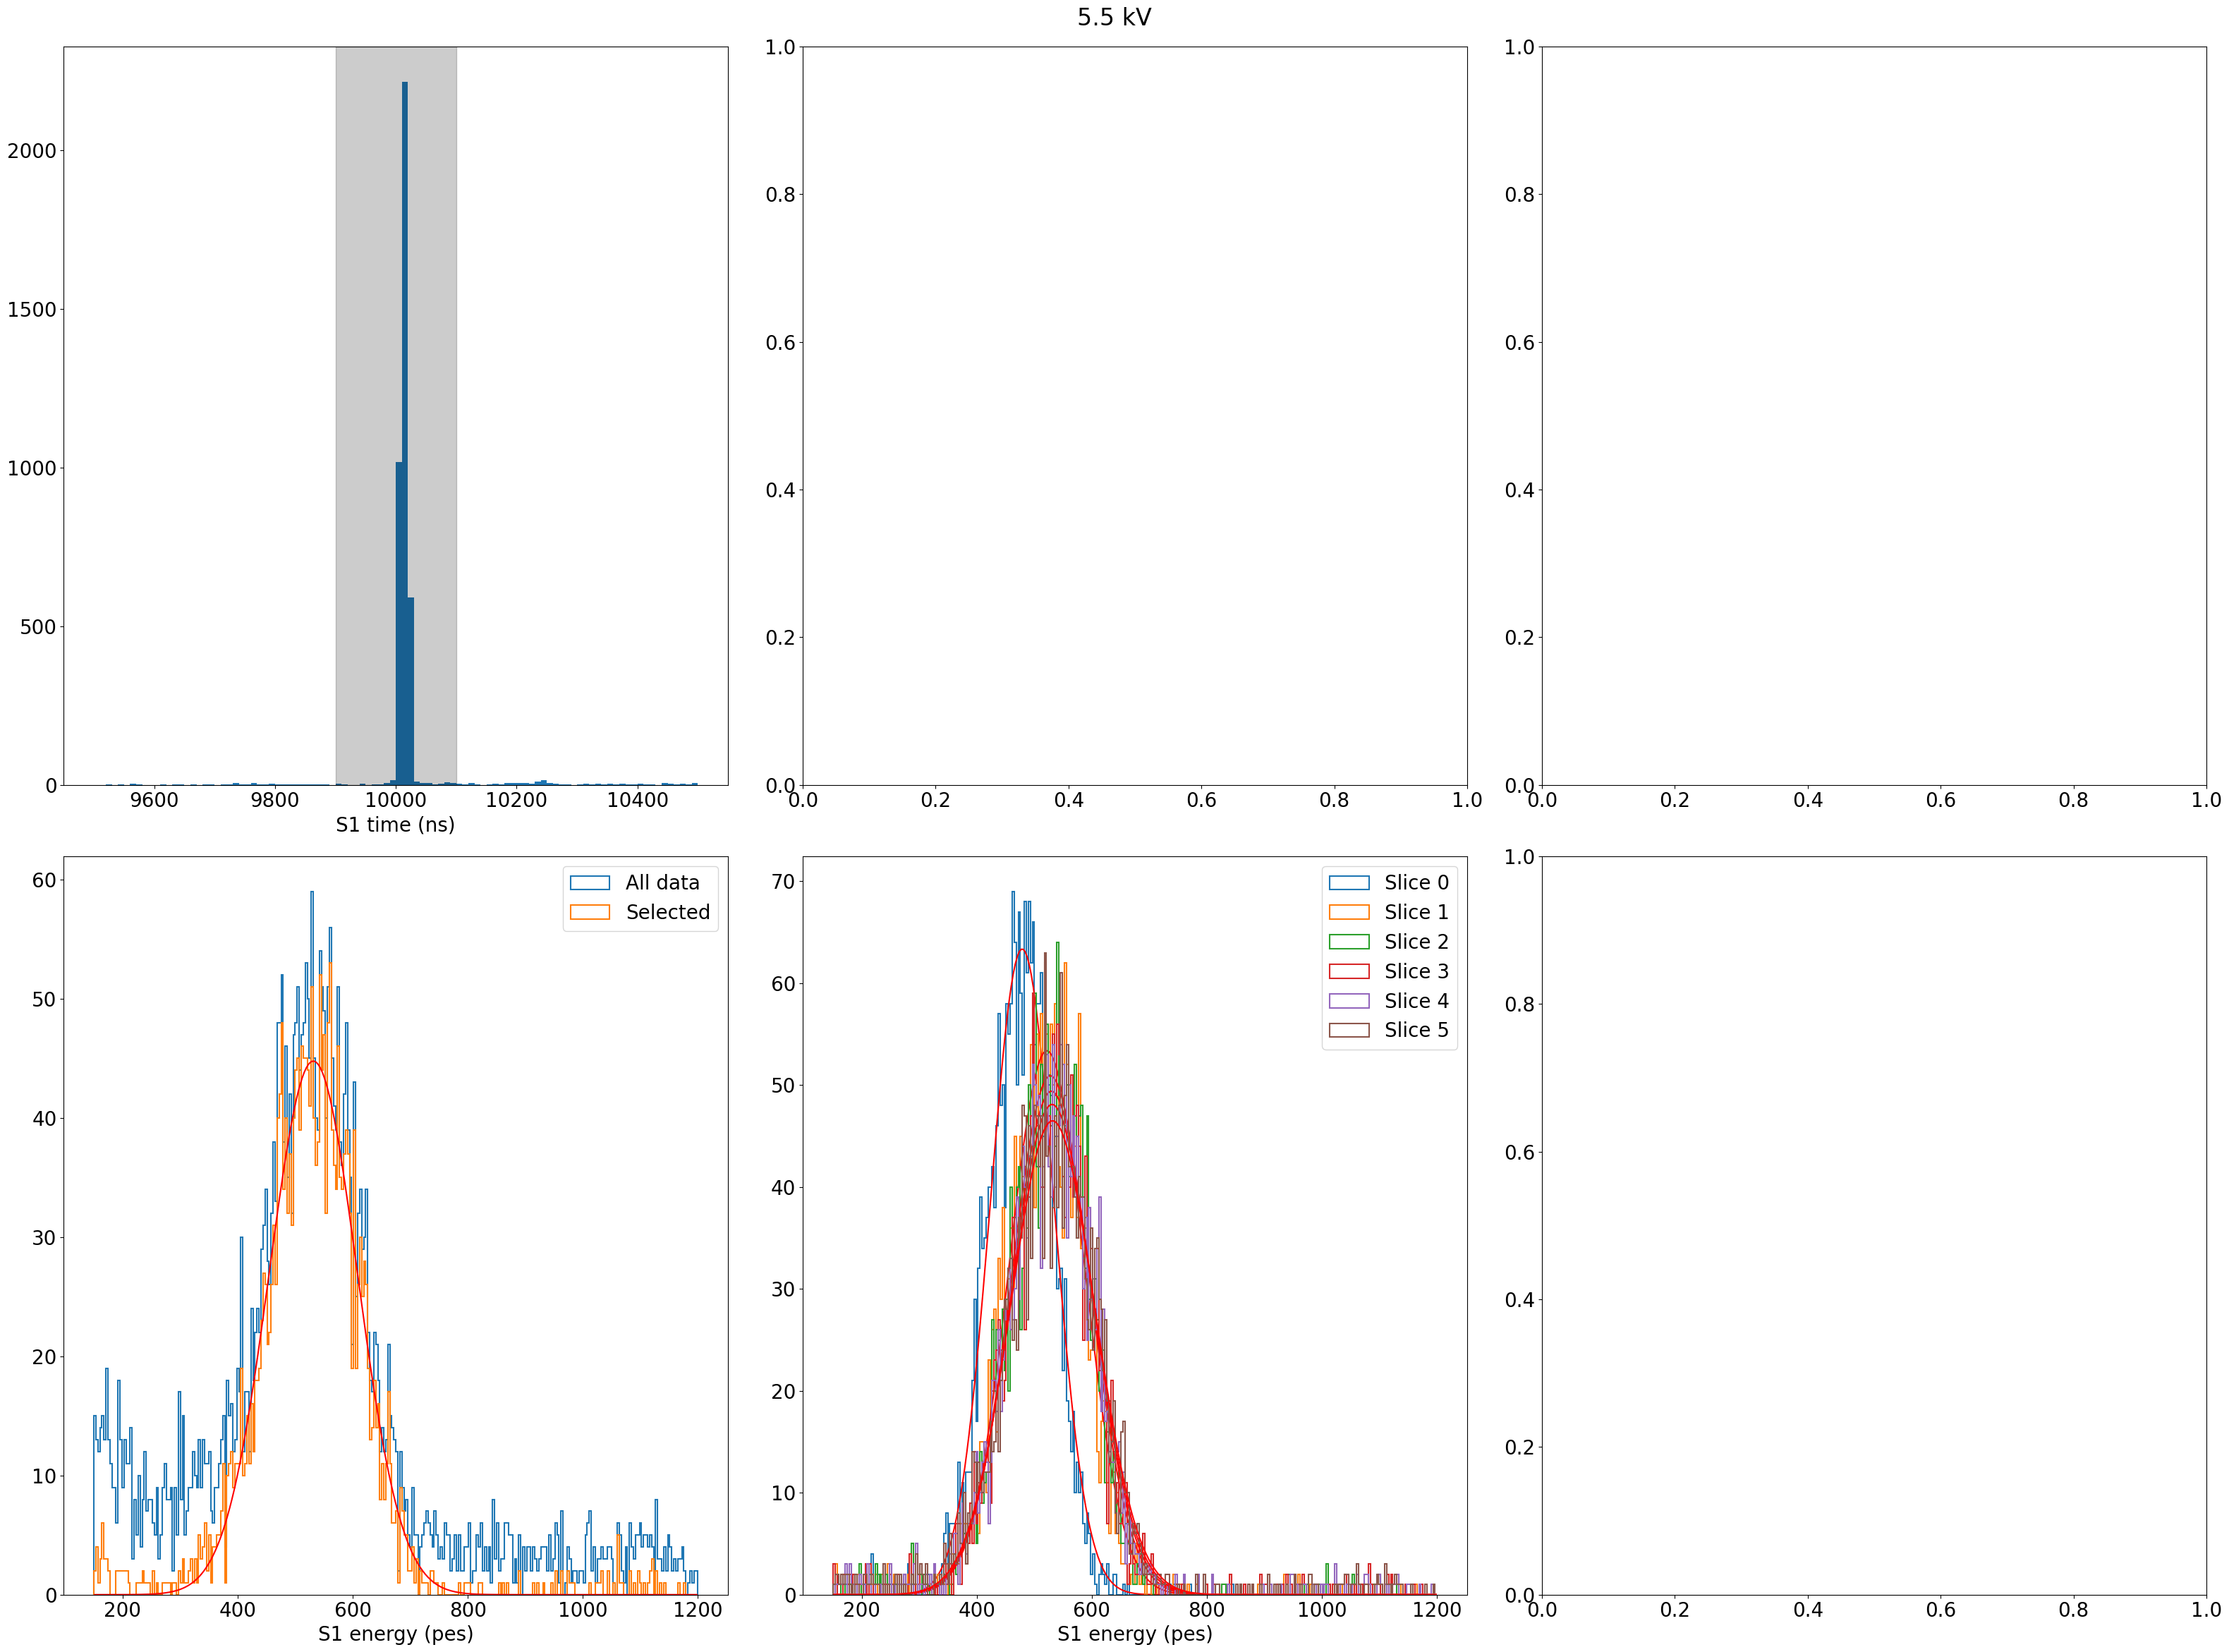

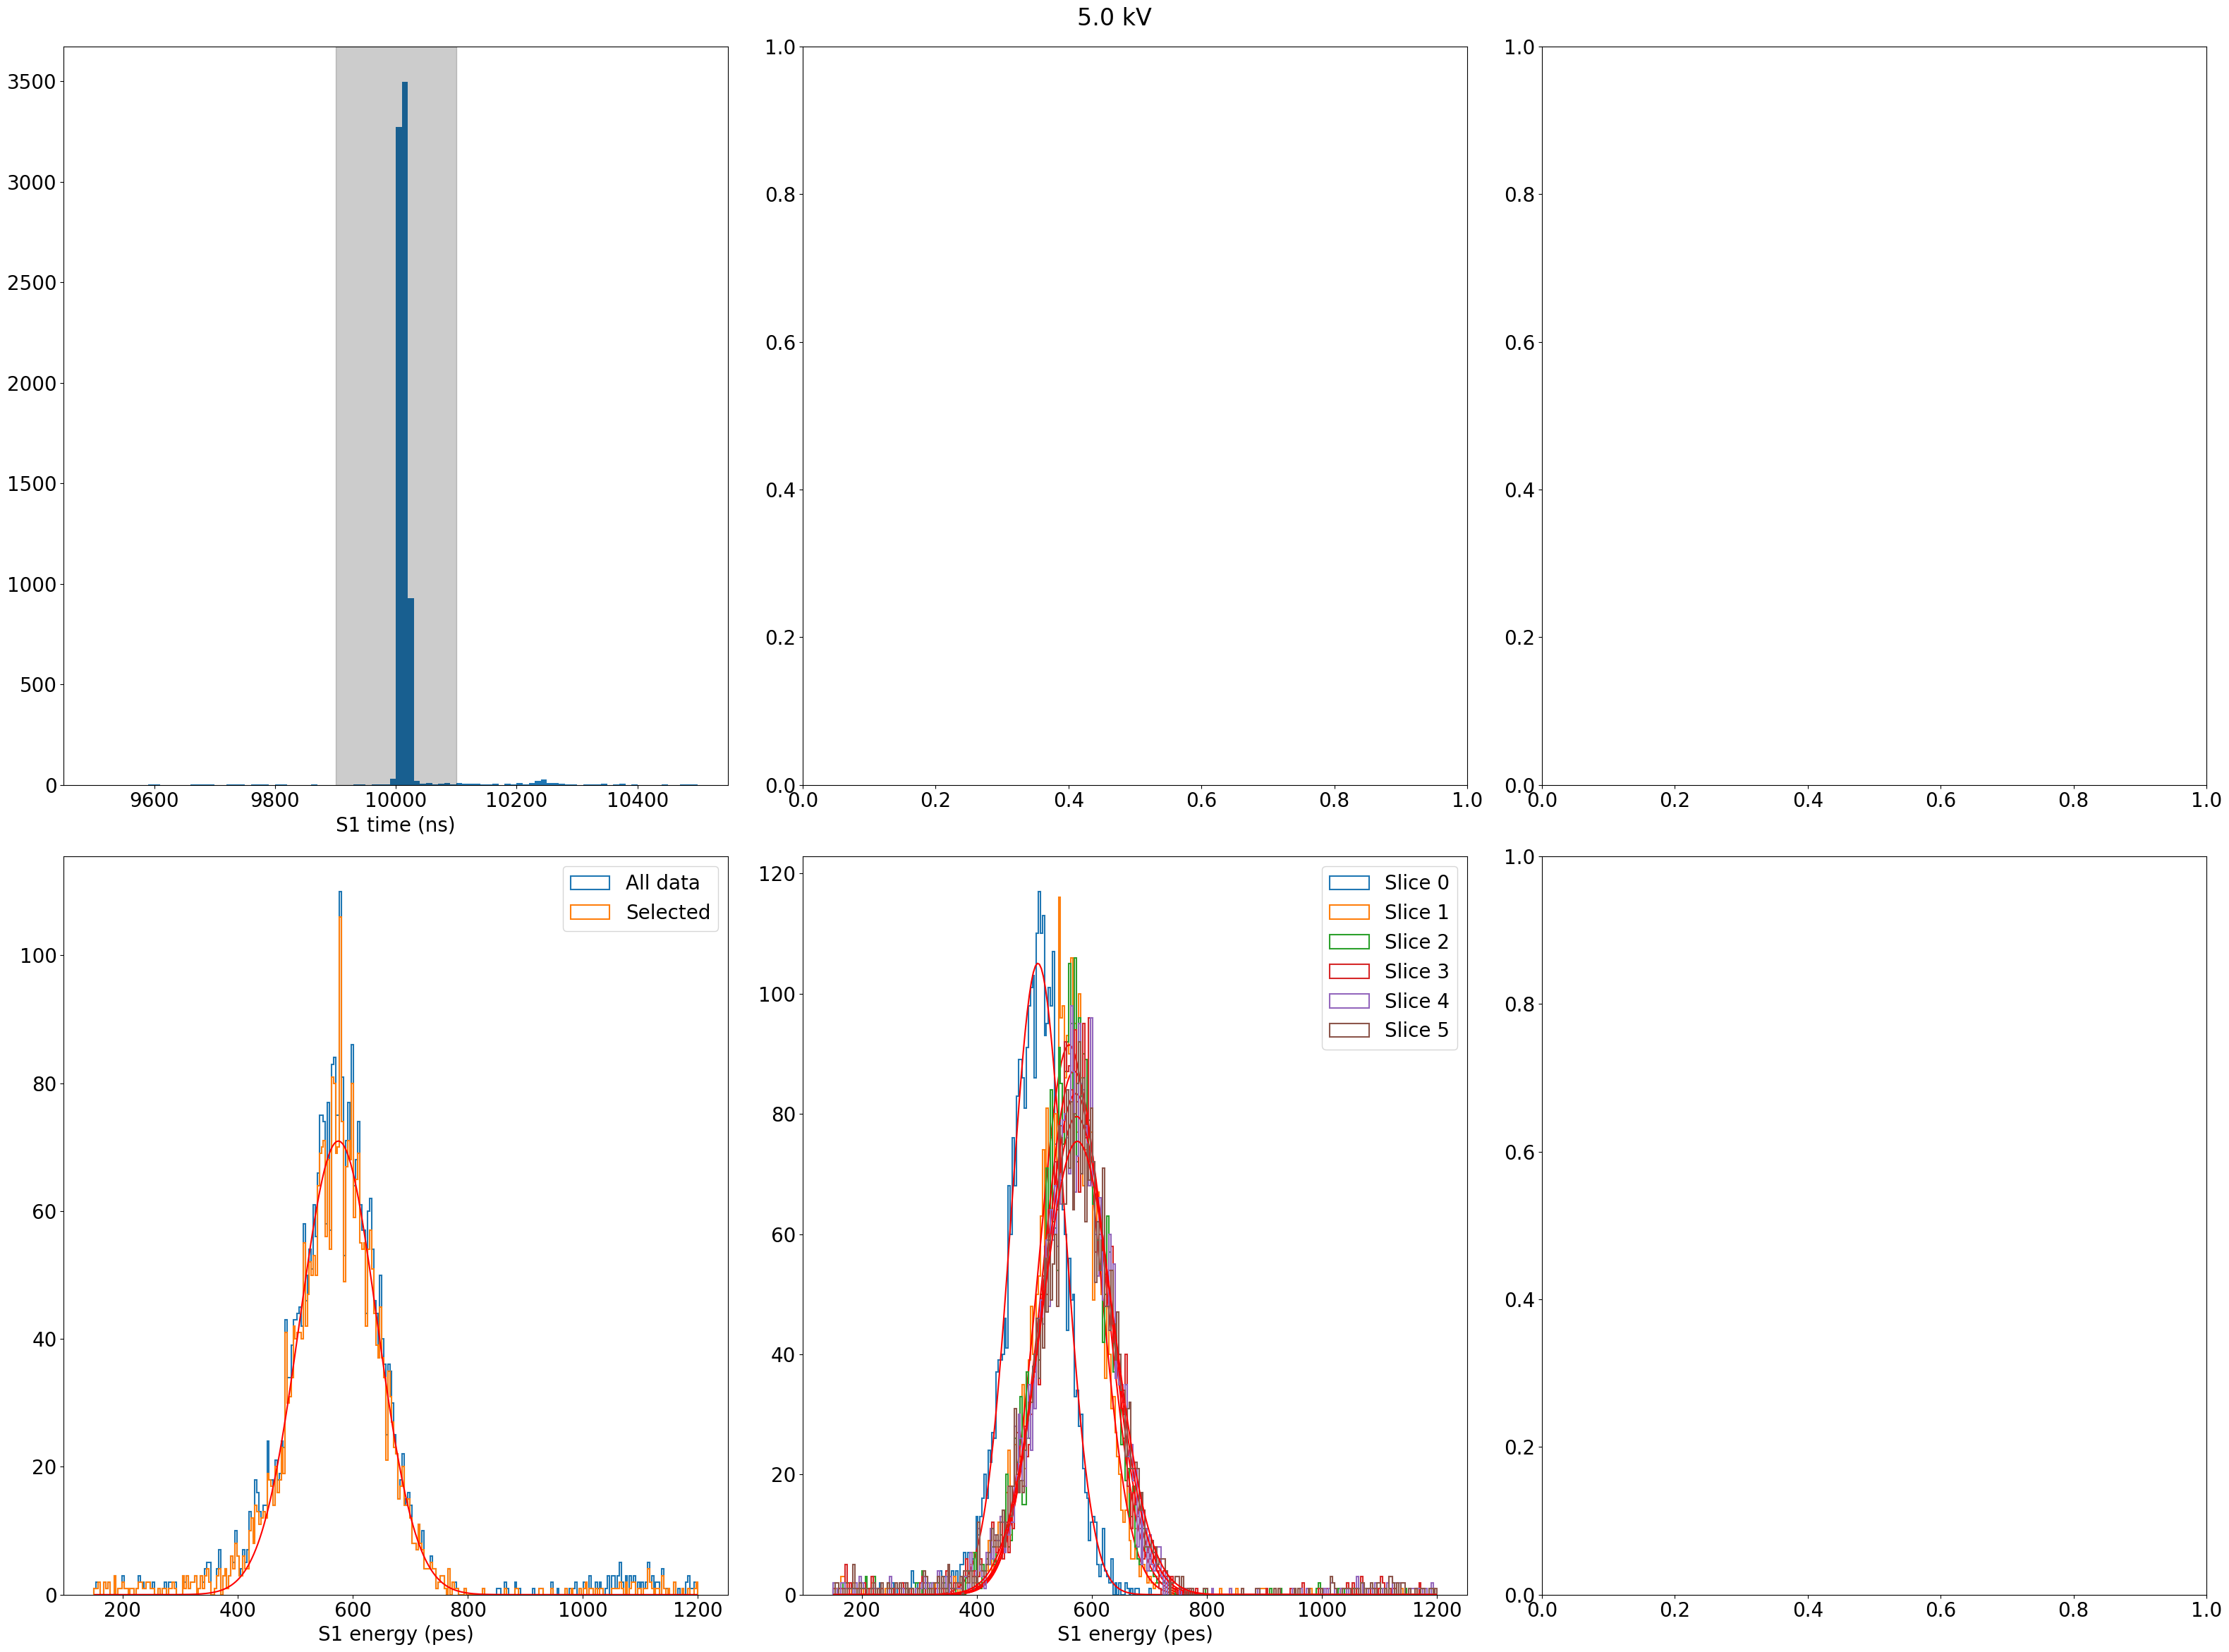

In [14]:
mus          = []
sigmas       = []
modes        = []
s2_mus       = []
mus_slice    = []
sigmas_slice = []

for jj, data, label_1, cv in zip(range(len(labels)), datasets_s2, labels, cath_volts):
    print(f'Run n = {jj}, ({label_1})')
    fig, axes = plt.subplots(2, 3, figsize=(32, 24))
    axes      = axes.flatten()
    
    sel_t_s1  = coref.in_range(data.s1_t, *trange_s1)
    
    axes[0].hist   (data.s1_t, s1_tbins);
    axes[0].axvspan(*trange_s1, alpha=0.2, color='k')
    axes[0].set_xlabel('S1 time (ns)')
    
    skip_flag = (cv-el_volt) > max_dv #& (cv - el_volt)
    
    if skip_flag:
    
        mode, trange_s2  = sel_trange_s2(data, s2_tbins, True, axes[1])
        sel_t_s2 = coref.in_range(data.s2_t, *trange_s2)
        axes[1].axvspan(*trange_s2, alpha=0.2, color='k')
        axes[1].set_xlabel('S2 time (ns)')
        
        #axes[2].hist2d(data.s1_energy, data.s2_energy, [s1_ebins, s2_ebins]);
        #sel_e_s2  = data.s2_energy > s2_emax
        #axes[2].axhline(s2_emax, c='r', lw=2)
        s2_e, erange_s2  = sel_erange_s2(data, s2_ebins, True, axes[2])
        sel_e_s2 = coref.in_range(data.s2_energy, *erange_s2)
        axes[2].axvspan(*erange_s2, alpha=0.2, color='k')
    
        axes[2].set_xlabel('S1 energy (pes)')
        axes[2].set_ylabel('S2 energy (pes)')
    
    sel = sel_t_s1 & sel_t_s2 & sel_e_s2 if skip_flag else sel_t_s1
    
    axes[3].hist(data     .s1_energy, s1_ebins, histtype='step', lw=1.5, label='All data');
    
    yd, xd, *_ = axes[3].hist(data[sel].s1_energy, s1_ebins, histtype='step', lw=1.5, label='Selected');
    axes[3].set_xlabel('S1 energy (pes)')

    xd    = coref.shift_to_bin_centers(xd)
    mod   = GaussianModel(prefix='g1_')
    pars  = mod.guess(yd, x=xd)
    out   = mod.fit(yd, pars, x=xd)
    result =  out.result.params
    
    axes[3].plot(xd, out.best_fit, '-', c='r')

    mu     = np.array([result['g1_center'].value, result['g1_center'].stderr])
    sigma  = np.array([result['g1_sigma' ].value, result['g1_sigma' ].stderr])
    
    mus   .append(mu)
    sigmas.append(sigma)
    modes .append(mode)
    s2_mus.append(s2_e if skip_flag else [0., 0.])

    mus_aux   = []
    sigma_aux = []
    s1_vals = np.zeros(len(data[sel]))
    for ii in range(6):
        s1_vals +=data[sel][f's1_energy_{ii}']
        yd, xd, *_ = axes[4].hist(s1_vals, s1_ebins, histtype='step', lw=1.5, label=f'Slice {ii}');
        axes[4].set_xlabel('S1 energy (pes)')
    
        xd    = coref.shift_to_bin_centers(xd)
        mod   = GaussianModel(prefix='g1_')
        pars  = mod.guess(yd, x=xd)
        out   = mod.fit(yd, pars, x=xd)
        result =  out.result.params
        
        axes[4].plot(xd, out.best_fit, '-', c='r')
    
        mu     = np.array([result['g1_center'].value, result['g1_center'].stderr])
        sigma  = np.array([result['g1_sigma' ].value, result['g1_sigma' ].stderr])
        
        mus_aux   .append(mu)
        sigma_aux.append(sigma)
    mus_slice   .append(mus_aux)
    sigmas_slice.append(sigma_aux)

    axes[3].legend()
    axes[4].legend()
    
    fig.suptitle(label_1)
    fig.tight_layout()

    
mus    = np.array(mus)
sigmas = np.array(sigmas)
modes  = np.array(modes )
s2_mus = np.array(s2_mus)

mus_slice    = np.array(mus_slice)
sigmas_slice = np.array(sigmas_slice)

In [11]:
#columns = ['pressure', 'run_number', 'el_voltage', 'cath_voltage', 'photons_kev', 'photons_kev_e', 'sigma_kev', 'sigma_kev_e']

drift_vol = np.where((cath_volts-el_volt)*1000 >=0, (cath_volts-el_volt)*1000, 0)


s1_data    = {f's1_photons_{v}'  : mus_slice   [:, v, 0] for v in range(6)}
s1_data_e  = {f's1_photons_{v}_e': mus_slice   [:, v, 1] for v in range(6)}
s1_sigma   = {f's1_sigma_{v}'    : sigmas_slice[:, v, 0] for v in range(6)}
s1_sigma_e = {f's1_sigma_{v}_e'  : sigmas_slice[:, v, 1] for v in range(6)}
data    = {'pressure'       :np.full(len(cath_volts), pressure),
           'run_number'     :np.array(all_runs).flatten(),
           'el_volt'        :np.full(len(cath_volts), el_volt),
           'cath_volt'      :cath_volts,
           'drift_volt'     :drift_vol,
           'drift_field'    :drift_vol/drift_dist,
           'drift_field_red':drift_vol/drift_dist/pressure,
           's1_photons'     :mus[:,0],
           's1_photons_e'   :mus[:,1],
           **s1_data,
           **s1_data_e,
           **s1_sigma,
           **s1_sigma_e,
           's2_photons'     :s2_mus[:,0],
           's2_photons_e'   :s2_mus[:,1],
           's1_sigma'       :sigmas[:,0],
           's1_sigma_e'     :sigmas[:,1],
           'resolution'     :sigmas[:,0]/mus[:,0] *235,
           'mode'           :modes[:,0],
           'mode_e'         :modes[:,1],
          }
dst = pd.DataFrame(data)
   
for i in range(6):
    if i == 0:
        dst[f's1_photons_d{i}'] = dst[f's1_photons_{i}']
    else:
        dst[f's1_photons_d{i}'] = dst[f's1_photons_{i}'] - dst[f's1_photons_{i-1}']
        
dst.to_hdf(dst_path, f'{source}_{pressure:.2f}bar_{gas}')

/home/ander/miniconda/envs/IC-3.8-2020-06-16/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '241Am_8.44bar_Ar'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Text(0, 0.5, 'S1 photons')

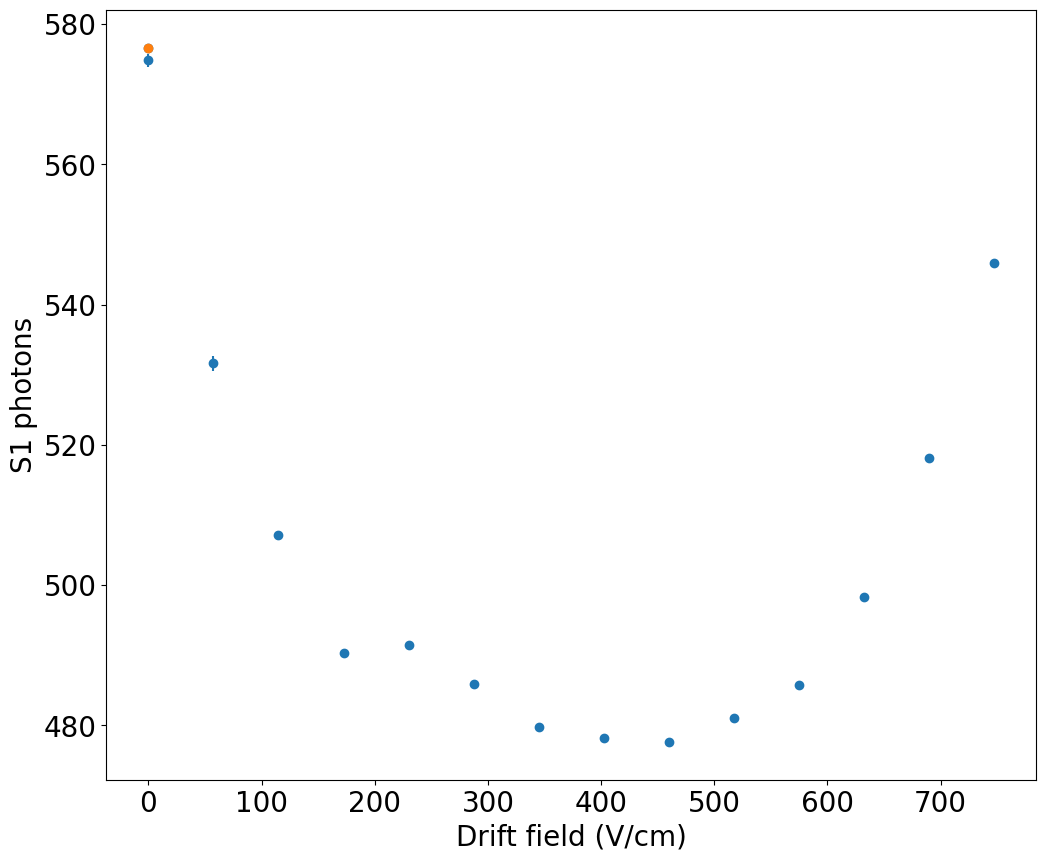

In [12]:
sel_ana = dst.drift_field>-1000
plt.errorbar(dst[sel_ana].drift_field, dst[sel_ana].s1_photons_5, yerr=dst[sel_ana].s1_photons_e, ls='', marker='o')
sel_ana = dst.cath_volt==0
plt.errorbar(dst[sel_ana].drift_field, dst[sel_ana].s1_photons_5, yerr=dst[sel_ana].s1_photons_e, ls='', marker='o')
plt.xlabel('Drift field (V/cm)')
plt.ylabel('S1 photons')
#plt.ylim(450, 470)

Text(0, 0.5, 'S1 photons')

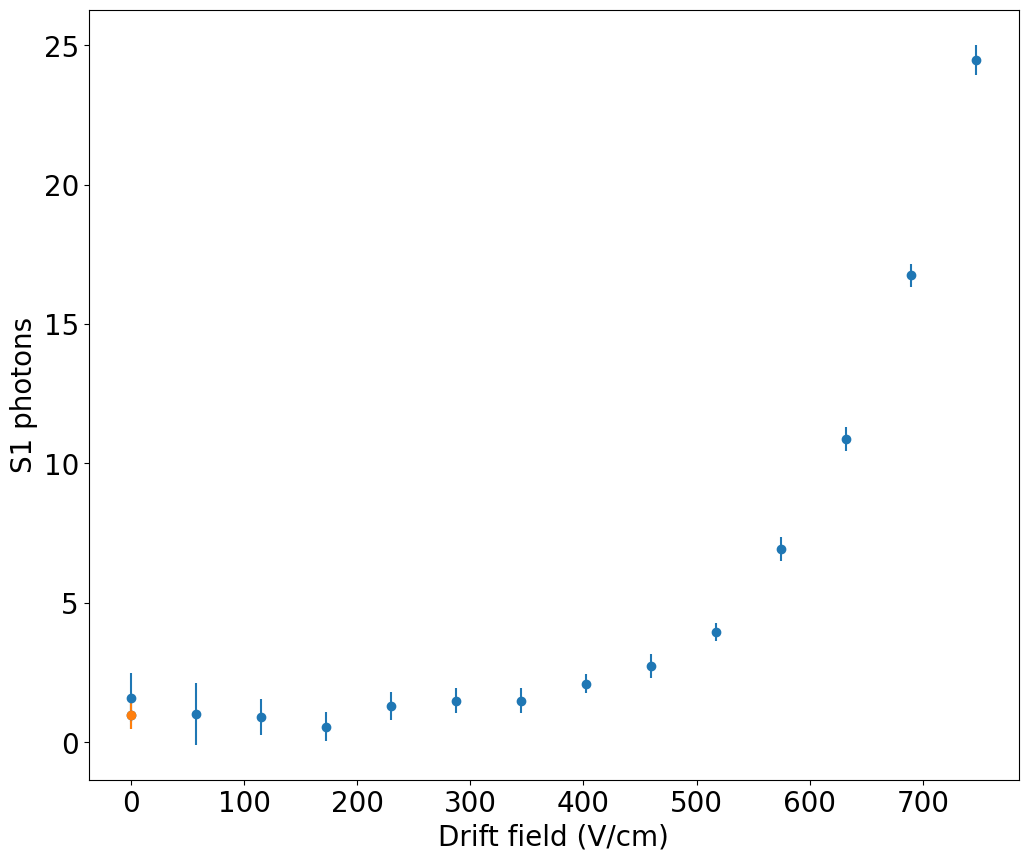

In [13]:
sel_ana = dst.drift_field>-1000
plt.errorbar(dst[sel_ana].drift_field, dst[sel_ana].s1_photons_d4, yerr=dst[sel_ana].s1_photons_e, ls='', marker='o')
sel_ana = dst.cath_volt==0
plt.errorbar(dst[sel_ana].drift_field, dst[sel_ana].s1_photons_d4, yerr=dst[sel_ana].s1_photons_e, ls='', marker='o')
plt.xlabel('Drift field (V/cm)')
plt.ylabel('S1 photons')
#plt.ylim(450, 470)

Text(0, 0.5, 'Drift time (µs)')

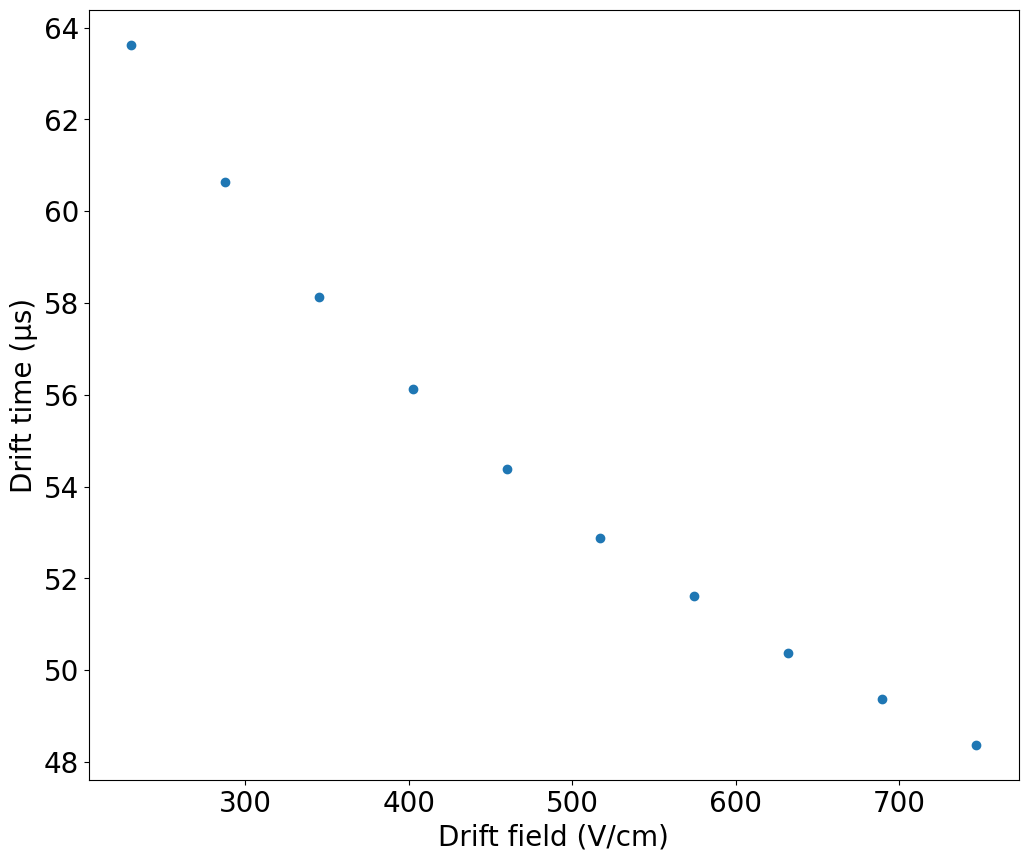

In [14]:
sel_ana = dst.drift_volt>1500
plt.errorbar(dst[sel_ana].drift_field, (dst[sel_ana]['mode']-10000)/1000, ls='', marker='o')
plt.xlabel('Drift field (V/cm)')
plt.ylabel('Drift time (µs)')

Text(0, 0.5, 'S2 photons')

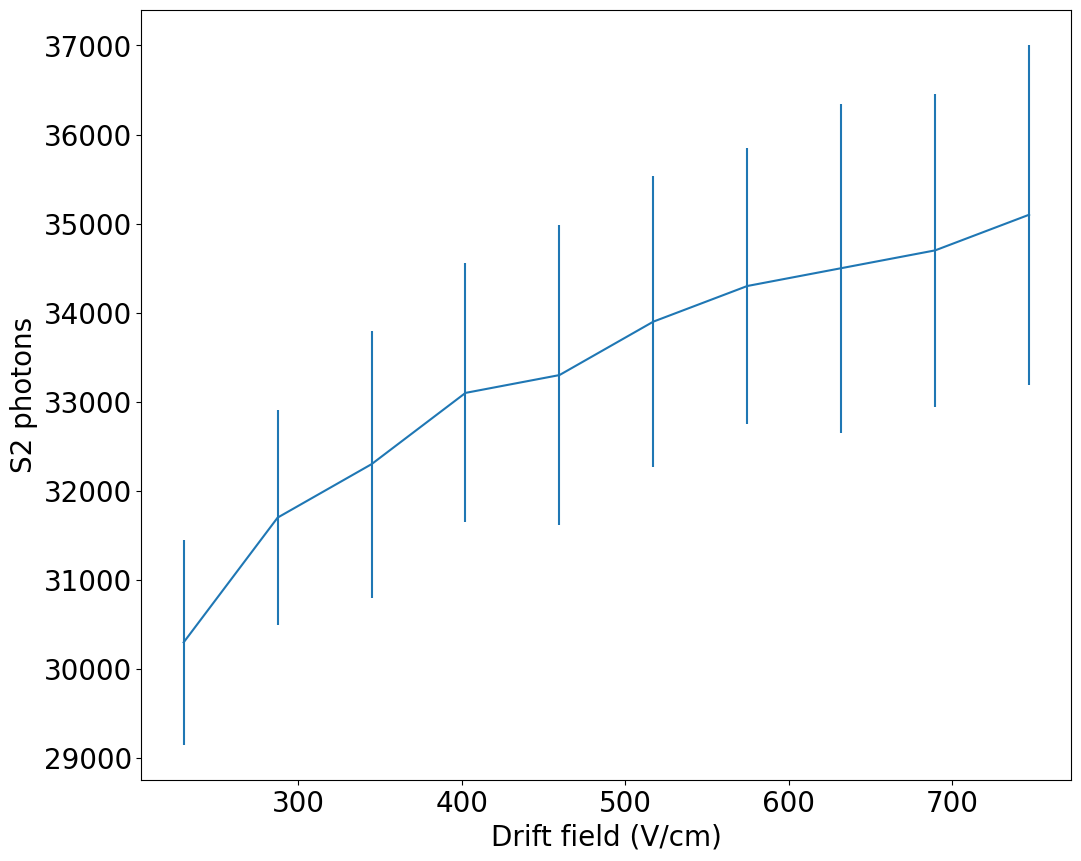

In [15]:
plt.errorbar(dst[sel_ana].drift_field, dst[sel_ana].s2_photons, yerr=dst[sel_ana].s2_photons_e)
plt.xlabel('Drift field (V/cm)')
plt.ylabel('S2 photons')

Text(0, 0.5, 'S2 photons')

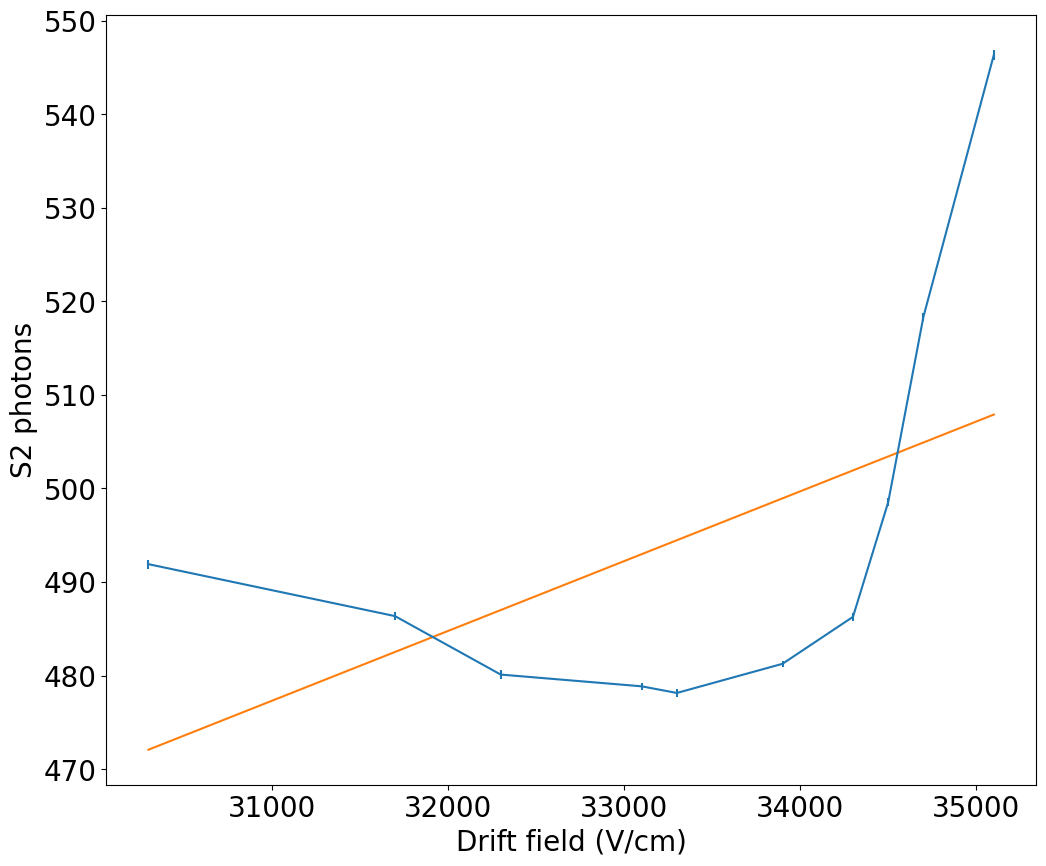

In [16]:
x, y  = dst[sel_ana].s2_photons, dst[sel_ana].s1_photons
z     = np.polyfit(x, y, 1)

plt.errorbar(x, y, yerr=dst[sel_ana].s1_photons_e)
plt.plot(x, z[1] + z[0] * x)
plt.xlabel('Drift field (V/cm)')
plt.ylabel('S2 photons')

In [17]:
z[1]

245.96436849884503

In [18]:
from symfit import parameters, variables, Fit, Model ,exp, Equality, GreaterThan, LessThan#, COBYLA
from symfit.core.objectives import LogLikelihood
from symfit.core.minimizers import COBYLA, BFGS

E, q_e, l_e            = variables ('E, q_e, l_e')
q1, q2, k2, lx, k, q0  = parameters('q1, q2, k2, lx, k, q0')

model = Model({
    l_e: lx + k * q0 *(1 - q1 + q2/(1+k2/E)/q0),
    q_e: q1 + q2/(1+k2/E),
})

fit = Fit(model, E=dst.drift_field.values, q_e=dst.s2_photons.values, l_e=dst.s1_photons.values, 
              constraints=[Equality(q1+q2, q0), GreaterThan(lx, 0), GreaterThan(k, 0), GreaterThan(k2, 0),
                           GreaterThan(q0, 0), GreaterThan(q1, 0), GreaterThan(q2, 0)])
       
fit_result = fit.execute()
print(fit_result)


Parameter Value        Standard Deviation
k         4.671149e-01 nan
k2        8.024929e-01 nan
lx        1.521595e+01 1.104058e+04
q0        2.751116e+01 nan
q1        1.924426e+01 nan
q2        9.265799e+00 2.961400e+02
Status message         Positive directional derivative for linesearch
Number of iterations   7
Objective              <symfit.core.objectives.LeastSquares object at 0x71e79494f8e0>
Minimizer              <symfit.core.minimizers.SLSQP object at 0x71e79665ca30>

Goodness of fit qualifiers:
chi_squared            11113123939.44227
objective_value        5556561969.721135
r_squared              -1.9863123949698176

Constraints:
--------------------
Question: -q0 + q1 + q2 == 0?
Answer:   0.9989001000000002

Question: lx >= 0?
Answer:   15.215949123034807

Question: k >= 0?
Answer:   0.4671149098437961

Question: k2 >= 0?
Answer:   0.8024928936468497

Question: q0 >= 0?
Answer:   27.51116284819191

Question: q1 >= 0?
Answer:   19.244264410886487

Question: q2 >= 0?
Answer

/home/ander/miniconda/envs/IC-3.8-2020-06-16/lib/python3.8/site-packages/symfit/core/fit_results.py:116: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.variance(param))


In [19]:
model(E=190, **fit_result.params)

ModelOutput(variables=[l_e, q_e], output=[array([-215.89713613]), array([26.39810235])])

In [20]:
0.03*35000*0.0059

6.195